In [1]:
# Cell 1: Import Libraries and Setup

# Import necessary libraries
import pandas as pd
import numpy as np
import re
import string
import time
import os
import warnings
from collections import defaultdict
import torch
import torch.nn.functional as F
from Levenshtein import distance as levenshtein_distance
from Levenshtein import jaro_winkler, ratio as levenshtein_ratio
import textdistance
from fuzzywuzzy import fuzz
import jellyfish
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Import transformers for BERT embeddings
try:
    from transformers import AutoTokenizer, AutoModel
    transformers_available = True
    print("Transformers library available for BERT embeddings")
except ImportError:
    transformers_available = False
    print("Warning: transformers library not available. Will use TF-IDF fallback.")

# Try to import pyahocorasick with fallback
try:
    import pyahocorasick
    aho_corasick_available = True
    print("pyahocorasick is available")
except ImportError:
    print("Warning: pyahocorasick not available. Using fallback implementation.")
    aho_corasick_available = False

# Suppress warnings
warnings.filterwarnings('ignore')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("All libraries imported successfully!")

Transformers library available for BERT embeddings
Using device: cpu
All libraries imported successfully!


In [15]:
# Cell 2: Enhanced BERT Embedder with MPNet Model

class EnhancedBERTEmbedder:
    """
    Enhanced BERT embedder using a stronger model with improved pooling strategies
    """
    
    def __init__(self, model_name='sentence-transformers/all-mpnet-base-v2', pooling_strategy='mean', device=None):
        """
        Initialize enhanced BERT embedder with specified pre-trained model and pooling strategy.
        
        Args:
            model_name (str): Name of the pre-trained BERT model to use
            pooling_strategy (str): Pooling strategy ('mean', 'cls', or 'max')
            device: Device to run the model on (cuda or cpu)
        """
        # IMPROVED: Better model selection
        # Check if stronger models are available and prefer them
        stronger_models = [
            'sentence-transformers/all-mpnet-base-v2',
            'sentence-transformers/paraphrase-mpnet-base-v2',
            'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
        ]
        
        self.model_name = model_name if model_name in stronger_models else stronger_models[0]
        self.pooling_strategy = pooling_strategy
        self.max_sequence_length = 512  # BERT's limit
        
        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
            
        self.initialized = False
        self.domain_adapted = False
        
        # Initialize pre-trained model if transformers available
        if transformers_available:
            try:
                print(f"Loading enhanced BERT model '{self.model_name}'...")
                self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
                self.model = AutoModel.from_pretrained(self.model_name).to(self.device)
                self.model.eval()  # Set to evaluation mode
                self.initialized = True
                print(f"Enhanced BERT model loaded successfully on {self.device}")
            except Exception as e:
                print(f"Error initializing BERT model: {e}")
                self.initialized = False
        
        # Initialize TF-IDF fallback with improved settings
        if not self.initialized:
            # IMPROVED: Using character n-grams for better handling of typos and abbreviations
            self.tfidf_vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 5))  # Increased n-gram range
            self.tfidf_fitted = False
            print("Using enhanced TF-IDF fallback for embeddings")
    
    # IMPROVED: Enhanced domain adaptation with better learning rate and steps
    def adapt_to_domain(self, examples_df, epochs=3):  # Increased epochs
        """
        Perform more extensive domain adaptation to improve merchant name understanding.
        
        Args:
            examples_df (DataFrame): DataFrame with matched merchant names
            epochs (int): Number of adaptation epochs
        """
        if not self.initialized or self.domain_adapted:
            return
        
        # Extract positive pairs (matching merchant names)
        positive_pairs = []
        if 'Enhanced_Score' in examples_df.columns:
            for _, row in examples_df.iterrows():
                if row['Enhanced_Score'] >= 0.7:  # Reduced threshold to get more examples
                    positive_pairs.append((row['Acronym'], row['Full_Name']))
        elif 'Expected_Match' in examples_df.columns:
            for _, row in examples_df.iterrows():
                if row['Expected_Match']:
                    positive_pairs.append((row['Acronym'], row['Full_Name']))
        
        # Skip if not enough examples
        if len(positive_pairs) < 5:
            print("Not enough high-quality examples for adaptation")
            return
        
        # Implement lightweight adaptation with contrastive learning
        self.model.train()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-5)  # Decreased learning rate
        
        print(f"Performing enhanced domain adaptation with {len(positive_pairs)} merchant name pairs...")
        for epoch in range(epochs):
            total_loss = 0
            for name1, name2 in positive_pairs:
                # Tokenize
                inputs = self.tokenizer([name1, name2], return_tensors='pt', padding=True, 
                                       truncation=True, max_length=self.max_sequence_length).to(self.device)
                
                # Forward pass
                outputs = self.model(**inputs)
                embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token embeddings
                
                # Contrastive loss (push matching names closer)
                similarity = F.cosine_similarity(embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0))
                loss = 1 - similarity
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(positive_pairs)
            print(f"  Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}")
        
        self.model.eval()
        self.domain_adapted = True
        print(f"Domain adaptation completed")
    
    def _mean_pooling(self, model_output, attention_mask):
        """
        Mean pooling - take average of all token embeddings
        """
        token_embeddings = model_output[0]  # First element contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def _cls_pooling(self, model_output, attention_mask):
        """
        CLS pooling - use the [CLS] token embedding
        """
        return model_output[0][:, 0]
    
    def _max_pooling(self, model_output, attention_mask):
        """
        Max pooling - take max of all token embeddings
        """
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
        return torch.max(token_embeddings, 1)[0]
    
    def _get_pooled_embeddings(self, model_output, attention_mask):
        """
        Apply the selected pooling strategy
        """
        if self.pooling_strategy == 'mean':
            return self._mean_pooling(model_output, attention_mask)
        elif self.pooling_strategy == 'cls':
            return self._cls_pooling(model_output, attention_mask)
        elif self.pooling_strategy == 'max':
            return self._max_pooling(model_output, attention_mask)
        else:
            # Default to mean pooling
            return self._mean_pooling(model_output, attention_mask)
    
    def fit(self, texts):
        """
        Fit the TF-IDF vectorizer on a corpus of texts (only needed for TF-IDF fallback)
        """
        if not self.initialized:
            # Fit TF-IDF vectorizer
            self.tfidf_vectorizer.fit(texts)
            self.tfidf_fitted = True
            print("TF-IDF vectorizer fitted on corpus")
    
    def encode(self, texts, batch_size=32, show_progress=False):
        """
        Encode texts into embeddings using the pre-trained model
        
        Args:
            texts: List of texts or single text
            batch_size: Batch size for processing
            show_progress: Whether to show progress
            
        Returns:
            numpy.ndarray: Embeddings for the texts
        """
        # Handle single text input
        if isinstance(texts, str):
            texts = [texts]
        
        # Return empty array for empty input
        if len(texts) == 0:
            return np.array([])
        
        # Use pre-trained BERT if available
        if self.initialized:
            # Process in batches
            all_embeddings = []
            
            for i in range(0, len(texts), batch_size):
                if show_progress and i % (batch_size * 10) == 0:
                    print(f"Processing batch {i//batch_size + 1}/{(len(texts)//batch_size) + 1}")
                
                batch_texts = texts[i:i+batch_size]
                
                # Tokenize
                encoded_input = self.tokenizer(
                    batch_texts, 
                    padding=True, 
                    truncation=True, 
                    max_length=self.max_sequence_length,
                    return_tensors='pt'
                ).to(self.device)
                
                # Compute token embeddings
                with torch.no_grad():
                    model_output = self.model(**encoded_input)
                    batch_embeddings = self._get_pooled_embeddings(model_output, encoded_input['attention_mask'])
                    all_embeddings.append(batch_embeddings.cpu().numpy())
            
            return np.vstack(all_embeddings)
        
        else:
            # Use TF-IDF fallback
            if not self.tfidf_fitted:
                self.fit(texts)
            
            return self.tfidf_vectorizer.transform(texts).toarray()
    
    def compute_similarity(self, text1, text2):
        """
        Compute cosine similarity between two texts using the pre-trained model
        
        Args:
            text1: First text
            text2: Second text
            
        Returns:
            float: Cosine similarity score
        """
        # Get embeddings for both texts
        emb1 = self.encode(text1)
        emb2 = self.encode(text2)
        
        # Compute cosine similarity
        return np.sum(emb1 * emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2) + 1e-8)

# Initialize enhanced BERT embedder with MPNet model
bert_embedder = EnhancedBERTEmbedder(model_name='sentence-transformers/all-mpnet-base-v2', device=device)
print("Enhanced BERT embedder initialized with MPNet model!")

Loading enhanced BERT model 'sentence-transformers/all-mpnet-base-v2'...
Enhanced BERT model loaded successfully on cpu
Enhanced BERT embedder initialized with MPNet model!


In [57]:
# 1. Add Australian-specific abbreviations and terms

def _get_australian_abbreviations(self):
    """Australian-specific abbreviation dictionary"""
    return {
        # Australian Government Organizations
        'aus': 'australian',
        'aust': 'australian',
        'australia': 'australian',
        'cth': 'commonwealth',
        'cwlth': 'commonwealth',
        'dept': 'department',
        'nsw': 'new south wales',
        'qld': 'queensland',
        'vic': 'victoria',
        'sa': 'south australia',
        'wa': 'western australia',
        'tas': 'tasmania',
        'nt': 'northern territory',
        'act': 'australian capital territory',
        
        # Common Australian Organization Terms
        'accc': 'australian competition and consumer commission',
        'asic': 'australian securities and investments commission',
        'apsc': 'australian public service commission',
        'ansto': 'australian nuclear science and technology organisation',
        'csiro': 'commonwealth scientific and industrial research organisation',
        'nrma': 'national roads and motorists association',
        'racq': 'royal automobile club of queensland',
        'racv': 'royal automobile club of victoria',
        'bhp': 'broken hill proprietary',
        'cpa': 'certified practising accountants australia',
        'amp': 'australian mutual provident',
        'qantas': 'queensland and northern territory aerial services',
        'csl': 'commonwealth serum laboratories',
        
        # Industry Terms
        'assoc': 'association',
        'org': 'organisation',
        'comm': 'commission',
        'cmte': 'committee',
        'auth': 'authority',
        'corp': 'corporation',
        'svc': 'service',
        'sci': 'science',
        'tech': 'technology'
    }

# 2. Enhance acronym formation detection for Australian organizations

def australian_acronym_formation_score(self, acronym, full_name):
    """
    Calculate how well the acronym matches the Australian organization naming pattern
    """
    # Clean inputs
    acronym = acronym.lower().strip()
    full_name = full_name.lower().strip()
    
    # Break full name into words
    words = [w for w in full_name.split() if len(w) > 1]
    
    # Get first letters of each significant word
    first_letters = ''.join([word[0] for word in words if word not in self.stopwords])
    
    # Handle special case for "Australian" organizations (very common)
    if 'australian' in full_name.lower() and acronym.lower().startswith('a'):
        # Remove 'australian' from calculation to focus on the rest
        words_without_australian = [w for w in words if w != 'australian']
        non_australian_first_letters = ''.join([w[0] for w in words_without_australian if w not in self.stopwords])
        
        # Check if rest of acronym matches non-Australian part
        rest_of_acronym = acronym.lower()[1:]
        if rest_of_acronym.lower() == non_australian_first_letters.lower():
            return 1.0
        
        # Partial match score for partial matches
        matched_chars = 0
        for i, char in enumerate(rest_of_acronym):
            if i < len(non_australian_first_letters) and char == non_australian_first_letters[i]:
                matched_chars += 1
        
        if len(rest_of_acronym) > 0:
            return 0.5 + (0.5 * matched_chars / len(rest_of_acronym))
    
    # Standard acronym matching
    if acronym.lower() == first_letters.lower():
        return 1.0
    
    # For partial matches - very common in Australian orgs
    match_score = 0
    for i, char in enumerate(acronym):
        if i < len(first_letters) and char.lower() == first_letters[i].lower():
            match_score += 1
    
    if len(acronym) > 0:
        return match_score / len(acronym)
    
    return 0.0

# 3. Add Australian organization pattern detection

def detect_australian_org_patterns(self, acronym, full_name):
    """
    Detect patterns specific to Australian organizations
    """
    patterns = {}
    
    # Australian government agency pattern
    if 'australian' in full_name.lower() and acronym.lower().startswith('a'):
        patterns['australian_govt_agency'] = 0.95
    
    # Commonwealth organization pattern
    if 'commonwealth' in full_name.lower() and acronym.lower().startswith('c'):
        patterns['commonwealth_org'] = 0.95
    
    # Royal organization pattern (e.g., RACV)
    if 'royal' in full_name.lower() and acronym.lower().startswith('r'):
        patterns['royal_organization'] = 0.95
    
    # National organization pattern
    if 'national' in full_name.lower() and acronym.lower().startswith('n'):
        patterns['national_org'] = 0.95
    
    # State-based organization pattern
    states = ['victoria', 'new south wales', 'queensland', 'western australia', 
              'south australia', 'tasmania', 'northern territory']
    if any(state in full_name.lower() for state in states):
        patterns['state_org'] = 0.90
    
    # Association pattern
    if 'association' in full_name.lower() and acronym.lower().endswith('a'):
        patterns['association'] = 0.90
    
    # Commission pattern
    if 'commission' in full_name.lower() and acronym.lower().endswith('c'):
        patterns['commission'] = 0.90
    
    # Industry pattern (specific sectors)
    industries = ['medical', 'pharmaceutical', 'financial', 'automotive', 
                 'technology', 'telecom', 'nuclear', 'science']
    for industry in industries:
        if industry in full_name.lower():
            patterns[f'{industry}_industry'] = 0.85
    
    return patterns

# 4. Optimize dynamic weights for Australian organizations

def get_australian_org_weights(self, acronym, full_name, domain=None):
    """
    Get weights optimized for Australian organizations
    """
    weights = {
        'jaro_winkler': 0.10,
        'damerau_levenshtein': 0.05,
        'tfidf_cosine': 0.05,
        'jaccard_bigram': 0.08,
        'soundex': 0.02,
        'token_sort_ratio': 0.10,
        'contains_ratio': 0.15,
        'fuzzy_levenshtein': 0.05,
        'australian_acronym_formation': 0.30,  # Much higher weight for acronym formation
        'bert_similarity': 0.10  # Lower weight for BERT (less important for acronyms)
    }
    
    # Adjust based on organization category
    if domain == 'Government':
        weights['australian_acronym_formation'] = 0.40  # Even higher for government orgs
        weights['contains_ratio'] = 0.20
        weights['jaro_winkler'] = 0.05
    elif domain == 'Automotive':
        weights['token_sort_ratio'] = 0.15
        weights['bert_similarity'] = 0.15
    elif domain == 'Financial':
        weights['fuzzy_levenshtein'] = 0.10
        weights['bert_similarity'] = 0.15
    
    # Normalize weights
    weight_sum = sum(weights.values())
    return {k: v/weight_sum for k, v in weights.items()}

# 5. Calculate enhanced score for Australian organizations

def compute_australian_enhanced_score(self, acronym, full_name, domain=None):
    """
    Compute enhanced score specifically optimized for Australian organizations
    """
    # Get all similarity scores
    scores = {}
    
    # Standard similarity metrics
    scores['jaro_winkler'] = self.jaro_winkler_similarity(acronym, full_name)
    scores['damerau_levenshtein'] = self.damerau_levenshtein_similarity(acronym, full_name)
    scores['tfidf_cosine'] = self.tfidf_cosine_similarity(acronym, full_name)
    scores['jaccard_bigram'] = self.jaccard_bigram_similarity(acronym, full_name)
    scores['soundex'] = self.soundex_similarity(acronym, full_name)
    scores['token_sort_ratio'] = self.token_sort_ratio_similarity(acronym, full_name)
    scores['contains_ratio'] = self.contains_ratio_similarity(acronym, full_name)
    scores['fuzzy_levenshtein'] = self.fuzzy_levenshtein_similarity(acronym, full_name)
    
    # Australia-specific metrics
    scores['australian_acronym_formation'] = self.australian_acronym_formation_score(acronym, full_name)
    
    # BERT similarity if available
    if hasattr(self, 'bert_similarity'):
        scores['bert_similarity'] = self.bert_similarity(acronym, full_name)
    
    # Get Australian-specific weights
    weights = self.get_australian_org_weights(acronym, full_name, domain)
    
    # Calculate weighted score
    weighted_score = 0
    weights_used = 0
    
    for algo, score in scores.items():
        if algo in weights:
            weighted_score += weights[algo] * score
            weights_used += weights[algo]
    
    # Normalize by weights used
    if weights_used > 0:
        weighted_score /= weights_used
    
    # Apply pattern-based boosting
    pattern_boost = 1.0
    patterns = self.detect_australian_org_patterns(acronym, full_name)
    
    for pattern, pattern_score in patterns.items():
        pattern_boost += 0.1  # Each pattern adds 10% boost
    
    # Apply special boost for perfect acronyms (very common in Australian organizations)
    if scores['australian_acronym_formation'] > 0.9:
        pattern_boost += 0.2  # 20% extra boost
    
    # Apply the pattern boost, cap at 1.5 (50% boost max)
    boosted_score = min(1.0, weighted_score * min(pattern_boost, 1.5))
    
    # IMPORTANT CHANGE: Special case for Australian govt organizations
    if 'australian' in full_name.lower() and scores['australian_acronym_formation'] > 0.7:
        boosted_score = max(boosted_score, 0.75)  # Ensure minimum score of 0.75
    
    return boosted_score

# 6. Adjust match category thresholds for Australian organizations

def add_australian_match_categories(results_df):
    """
    Add match categories with thresholds optimized for Australian organizations
    """
    # Lower thresholds for Australian organizations
    thresholds = {
        'Exact Match': 0.90,    # Was 0.95
        'Strong Match': 0.75,   # Was 0.85
        'Probable Match': 0.60, # Was 0.75
        'Possible Match': 0.50, # Was 0.65
        'Weak Match': 0.45,     # Was 0.50
        'No Match': 0.0
    }
    
    df = results_df.copy()
    
    # Add category column based on Enhanced_Score
    df['Match_Category'] = 'No Match'
    
    # Apply thresholds in reverse order (highest first)
    for category, threshold in sorted(thresholds.items(), key=lambda x: x[1], reverse=True):
        df.loc[df['Enhanced_Score'] >= threshold, 'Match_Category'] = category
    
    return df

# 7. Process merchant data with Australian organization optimization

def process_australian_merchant_data(merchant_df, merchant_matcher):
    """
    Process merchant data with optimizations for Australian organizations
    """
    start_time = time.time()
    print(f"Processing {len(merchant_df)} Australian organization entries...")
    
    # Create a copy of the input DataFrame
    results_df = merchant_df.copy()
    
    # Add columns for similarity scores
    results_df['Basic_Score'] = 0.0
    results_df['Enhanced_Score'] = 0.0
    
    # Process each entry
    for idx, row in results_df.iterrows():
        acronym = row['Acronym']
        full_name = row['Full_Name']
        category = row['Merchant_Category']
        
        # Basic preprocessing
        acronym = str(acronym).strip()
        full_name = str(full_name).strip()
        
        # Special handling for certain Australian patterns
        if 'australian' in full_name.lower() and acronym.startswith('A'):
            # Apply acronym formation score
            acronym_score = merchant_matcher.australian_acronym_formation_score(acronym, full_name)
            
            # If strong acronym formation, boost the score
            if acronym_score > 0.8:
                basic_score = max(0.7, merchant_matcher.compute_weighted_score(acronym, full_name, category))
                enhanced_score = max(0.8, merchant_matcher.compute_australian_enhanced_score(acronym, full_name, category))
            else:
                # Use standard computation but with Australian optimization
                basic_score = merchant_matcher.compute_weighted_score(acronym, full_name, category)
                enhanced_score = merchant_matcher.compute_australian_enhanced_score(acronym, full_name, category)
        else:
            # Standard computation with Australian optimization
            basic_score = merchant_matcher.compute_weighted_score(acronym, full_name, category)
            enhanced_score = merchant_matcher.compute_australian_enhanced_score(acronym, full_name, category)
        
        # Store scores
        results_df.at[idx, 'Basic_Score'] = basic_score
        results_df.at[idx, 'Enhanced_Score'] = enhanced_score
    
    total_time = time.time() - start_time
    print(f"Processing completed in {total_time:.2f} seconds")
    
    # Apply Australian-optimized match categories
    results_df = add_australian_match_categories(results_df)
    
    return results_df

In [59]:
# Cell 3: Enhanced Merchant Matcher with Improved Pattern Recognition

class EnhancedMerchantMatcher:
    """
    Enhanced matcher with improved pattern recognition for merchant name matching.
    Uses multiple similarity algorithms and domain-specific patterns.
    """
    
    def __init__(self, bert_embedder=None):
        """
        Initialize with enhanced BERT embedder.
        
        Args:
            bert_embedder: Enhanced BERT embedder instance
        """
        # Initialize enhanced BERT embedder
        self.bert_embedder = bert_embedder
        if self.bert_embedder is None and transformers_available:
            self.bert_embedder = EnhancedBERTEmbedder()
        
        # Initialize TF-IDF vectorizer
        self.tfidf_vectorizer = TfidfVectorizer()
        
        # Initialize trie for approximate matching
        self.trie = None
        
        # Initialize Aho-Corasick automaton only if available
        if aho_corasick_available:
            self.automaton = pyahocorasick.Automaton()
        else:
            self.automaton = None
        
        # Define abbreviation dictionary - comprehensive industry knowledge 
        self.abbreviations = self._get_abbreviation_dictionary()
        
        # Domain-specific abbreviations
        self.domain_abbreviations = self._get_domain_abbreviations()
        
        # Stop words to remove during preprocessing
        self.stopwords = self._get_stopwords()
        
        # Domain-specific stopwords
        self.domain_stopwords = self._get_domain_stopwords()
    
    def _get_abbreviation_dictionary(self):
        """Get comprehensive abbreviation dictionary with more merchant-specific terms"""
        base_dict = {
            # Banking & Financial Institutions (expanded)
            'bofa': 'bank of america', 'b of a': 'bank of america',
            'boa': 'bank of america', 'bac': 'bank of america',
            'jpm': 'jpmorgan chase', 'jpm chase': 'jpmorgan chase',
            'jpmc': 'jpmorgan chase', 'chase': 'jpmorgan chase',
            'wf': 'wells fargo', 'wfb': 'wells fargo bank',
            'citi': 'citibank', 'citi bank': 'citibank',
            'gs': 'goldman sachs', 'ms': 'morgan stanley',
            'db': 'deutsche bank', 'hsbc': 'hongkong and shanghai banking corporation',
            'amex': 'american express', 'amx': 'american express',
            'usb': 'us bank', 'rbc': 'royal bank of canada',
            'pnc': 'pnc financial services', 'td': 'toronto dominion bank',
            'bny': 'bank of new york', 'bnyc': 'bank of new york mellon',
            'cba': 'commonwealth bank of australia', 'nab': 'national australia bank',
            'rba': 'reserve bank of australia', 'westpac': 'western pacific bank',
            'fargo': 'wells fargo', 'chase bank': 'jpmorgan chase',
            'usaa': 'united services automobile association',
            
            # Fast Food & Restaurant Chains (expanded)
            'mcd': 'mcdonalds', 'mcds': 'mcdonalds', 'md': 'mcdonalds',
            'mickey ds': 'mcdonalds', 'maccas': 'mcdonalds',
            'bk': 'burger king', 'kfc': 'kentucky fried chicken',
            'sbux': 'starbucks', 'sb': 'starbucks', 'starbks': 'starbucks',
            'tb': 'taco bell', 'wen': 'wendys', 'wendys': 'wendys restaurant',
            'dq': 'dairy queen', 'ph': 'pizza hut', 'pzh': 'pizza hut',
            'dnkn': 'dunkin donuts', 'cfa': 'chick fil a',
            'cmg': 'chipotle mexican grill', 'chipotle': 'chipotle mexican grill',
            'ihop': 'international house of pancakes',
            'tgi': 'tgi fridays', 'tgif': 'tgi fridays',
            'bww': 'buffalo wild wings', 'pjs': 'papa johns',
            'ljs': 'long john silvers', 'popeyes': 'popeyes louisiana kitchen',
            'subway': 'subway restaurant', 'dominos': 'dominos pizza',
            
            # Retail & Supermarkets (expanded)
            'wmt': 'walmart', 'wal mart': 'walmart', 'walm': 'walmart',
            'tgt': 'target', 'targ': 'target', 'tarjay': 'target',
            'costco': 'costco wholesale', 'cost': 'costco',
            'kroger': 'the kroger co', 'krg': 'kroger',
            'cvs': 'cvs pharmacy', 'cvs rx': 'cvs pharmacy',
            'wag': 'walgreens', 'walg': 'walgreens',
            'hd': 'home depot', 'thd': 'the home depot',
            'low': 'lowes', 'lowes': 'lowes home improvement',
            'bby': 'best buy', 'bb': 'best buy',
            'amzn': 'amazon', 'amazon': 'amazon.com',
            '711': '7-eleven', '7-11': '7-eleven',
            
            # Tech Companies (expanded)
            'msft': 'microsoft', 'ms': 'microsoft', 'aapl': 'apple',
            'goog': 'google', 'googl': 'google', 'alphabet': 'google',
            'amzn': 'amazon', 'fb': 'facebook', 'meta': 'meta platforms',
            'nflx': 'netflix', 'tsla': 'tesla motors', 'tsla': 'tesla',
            'ibm': 'international business machines', 'csco': 'cisco systems',
            'orcl': 'oracle', 'intc': 'intel', 'amd': 'advanced micro devices',
            'nvda': 'nvidia', 'adbe': 'adobe', 'crm': 'salesforce',
            'dell': 'dell technologies', 'hpe': 'hewlett packard enterprise',
            'hp': 'hewlett packard',
            
            # Common address components (expanded)
            'rd': 'road', 'st': 'street', 'ave': 'avenue', 
            'blvd': 'boulevard', 'ctr': 'center', 'ln': 'lane', 
            'dr': 'drive', 'pl': 'place', 'ct': 'court',
            'hwy': 'highway', 'pkwy': 'parkway', 'sq': 'square',
            'cir': 'circle', 'ter': 'terrace', 'expy': 'expressway',
            'fwy': 'freeway', 'tpke': 'turnpike', 'crk': 'creek',
            'hvn': 'haven', 'xing': 'crossing', 'vlg': 'village',
            'spgs': 'springs', 'mtn': 'mountain', 'lk': 'lake',
            'n': 'north', 's': 'south', 'e': 'east', 'w': 'west',
            'ne': 'northeast', 'nw': 'northwest', 'se': 'southeast',
            'sw': 'southwest',
            
            # Expanded location-based prefixes
            'norcal': 'northern california', 'socal': 'southern california',
            'nyc': 'new york city', 'la': 'los angeles', 'sf': 'san francisco',
            'chi': 'chicago', 'atl': 'atlanta', 'hou': 'houston',
            'dfw': 'dallas fort worth', 'mia': 'miami', 'bos': 'boston',
            'dc': 'washington dc', 'sea': 'seattle', 'den': 'denver'
        }

   
            # Add hundreds more abbreviations...
        return base_dict
    
    def _get_domain_abbreviations(self):
        """Get domain-specific abbreviation dictionaries"""
        return {
            'Medical': {
                'dr': 'doctor', 'hosp': 'hospital', 'med': 'medical',
                'clin': 'clinic', 'pharm': 'pharmacy', 'lab': 'laboratory',
                'dept': 'department', 'ctr': 'center', 'inst': 'institute',
                'er': 'emergency room', 'icu': 'intensive care unit',
                'ob': 'obstetrics', 'gyn': 'gynecology', 'peds': 'pediatrics',
                'ortho': 'orthopedics', 'onc': 'oncology', 'neuro': 'neurology'
            },
            'Government': {
                'govt': 'government', 'dept': 'department', 'admin': 'administration',
                'auth': 'authority', 'fed': 'federal', 'natl': 'national',
                'comm': 'commission', 'sec': 'secretary', 'org': 'organization',
                'div': 'division', 'bur': 'bureau', 'off': 'office',
                'min': 'ministry', 'reg': 'regional', 'dist': 'district',
                'cncl': 'council', 'cmte': 'committee', 'subcmte': 'subcommittee'
            },
            'Education': {
                'univ': 'university', 'coll': 'college', 'acad': 'academy',
                'elem': 'elementary', 'sch': 'school', 'inst': 'institute',
                'dept': 'department', 'lib': 'library', 'lab': 'laboratory',
                'fac': 'faculty', 'prof': 'professor', 'assoc': 'associate',
                'asst': 'assistant', 'adm': 'administration', 'stdnt': 'student',
                'grad': 'graduate', 'undergrad': 'undergraduate'
            },
            'Financial': {
                'fin': 'financial', 'svcs': 'services', 'mgmt': 'management',
                'assoc': 'associates', 'intl': 'international', 'grp': 'group',
                'corp': 'corporation', 'cap': 'capital', 'inv': 'investment',
                'asset': 'asset management', 'sec': 'securities', 'adv': 'advisors',
                'tr': 'trust', 'port': 'portfolio', 'acct': 'account',
                'bal': 'balance', 'stmt': 'statement', 'equ': 'equity'
            },
            'Restaurant': {
                'rest': 'restaurant', 'cafe': 'cafeteria', 'grill': 'grillery',
                'brew': 'brewery', 'bar': 'bar and grill', 'bbq': 'barbecue',
                'deli': 'delicatessen', 'stk': 'steakhouse', 'bf': 'breakfast',
                'din': 'dinner', 'chs': 'cheese', 'ckn': 'chicken'
            }
        }
    
    def _get_stopwords(self):
        """Get general stopwords for preprocessing"""
        return {
            'inc', 'llc', 'co', 'ltd', 'corp', 'plc', 'na', 'the', 
            'and', 'of', 'for', 'in', 'a', 'an', 'by', 'to', 'at',
            'corporation', 'incorporated', 'company', 'limited',
            'with', 'from', 'as', 'on', 'group', 'services'
        }
    
    def _get_domain_stopwords(self):
        """Get domain-specific stopwords"""
        return {
            'Medical': {'center', 'healthcare', 'medical', 'health', 'care', 'services', 'clinic', 'hospital'},
            'Government': {'department', 'office', 'agency', 'bureau', 'division', 'authority', 'administration'},
            'Education': {'university', 'college', 'school', 'institute', 'academy', 'education', 'learning'},
            'Financial': {'financial', 'services', 'management', 'capital', 'investment', 'banking', 'advisor'},
            'Restaurant': {'restaurant', 'cafe', 'diner', 'eatery', 'grill', 'kitchen', 'bar', 'house'}
        }
    
    def enhanced_preprocessing(self, text, domain=None):
        """Enhanced preprocessing with better merchant-specific handling"""
        if not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Better handling of punctuation - preserve apostrophes in business names
        # Current implementation doesn't fully handle special cases
        text = re.sub(r'([^a-z0-9\'\.\&\-])', ' ', text)
        
        # IMPROVED: Special handling for business name apostrophes with multiple patterns
        text = re.sub(r'\'s\b', 's', text)  # Convert McDonald's to McDonalds
        text = re.sub(r'\'', '', text)      # Remove remaining apostrophes
        
        # IMPROVED: Handle special characters in company names
        text = re.sub(r'&amp;', '&', text)  # Fix HTML entities
        text = re.sub(r'@', 'at', text)     # Replace @ with 'at'
        
        # IMPROVED: Normalize spaces and remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        # IMPROVED: Expand common business suffixes with more variations
        business_suffixes = {
            r'\bco\b': 'company',
            r'\binc\b': '',          # Remove Inc entirely
            r'\bltd\b': 'limited',
            r'\bllc\b': '',          # Remove LLC entirely
            r'\bcorp\b': '',         # Remove Corp entirely
            r'\bcorporation\b': '',  # Remove when processing full names for matching
            r'\blimited\b': '',      # Remove when processing full names for matching
            r'\bcompany\b': '',      # Remove when processing full names for matching
            r'\bltda\b': '',         # Remove LTDA (international)
            r'\bgmbh\b': '',         # Remove GmbH (German companies)
            r'\bsa\b': '',           # Remove SA (international)
            r'\bpvt\b': '',          # Remove PVT (private companies)
            r'\bplc\b': '',          # Remove PLC (public limited companies)
            r'\bag\b': ''            # Remove AG (German companies)
        }
        
        for suffix, replacement in business_suffixes.items():
            text = re.sub(suffix, replacement, text)
        
        # Split words for further processing
        words = text.split()
        
        # Apply general abbreviation expansion with more expansions
        words = [self.abbreviations.get(word, word) for word in words]
        
        # Apply domain-specific abbreviation expansion if domain is provided
        if domain and domain in self.domain_abbreviations:
            words = [self.domain_abbreviations[domain].get(word, word) for word in words]
        
        # IMPROVED: Enhanced handling for common merchant name patterns
        if 'mc' in words or any('mc' in word for word in words):
            # McDonalds pattern handling
            words = ['mcdonalds' if word.lower() in ['mcd', 'mcds', 'mcdon', 'mcdonald', 'mcdonalds'] 
                    else word for word in words]
        
        # IMPROVED: Better handling for Walmart variations
        if any(word in ['wmt', 'wal', 'walmart', 'walm'] for word in words):
            words = ['walmart' if word.lower() in ['wmt', 'wal', 'walm', 'walmart'] 
                    else word for word in words]
        
        # IMPROVED: Create expanded stopwords for this domain
        expanded_stopwords = self.stopwords.copy()
        if domain and domain in self.domain_stopwords:
            expanded_stopwords.update(self.domain_stopwords[domain])
        
        # IMPROVED: Remove domain-specific stopwords with expanded list
        words = [word for word in words if word not in expanded_stopwords]
        
        # Rejoin words and remove extra spaces
        text = ' '.join(words)
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def preprocess_pair(self, acronym, full_name, domain=None):
        """Preprocess acronym and full name with domain-specific handling"""
        acronym_clean = self.enhanced_preprocessing(acronym, domain)
        full_name_clean = self.enhanced_preprocessing(full_name, domain)
        return acronym_clean, full_name_clean
    
    # The remaining similarity methods will be included in the next cells...

# Initialize enhanced merchant matcher with BERT embedder
merchant_matcher = EnhancedMerchantMatcher(bert_embedder=bert_embedder)
print("Enhanced merchant matcher initialized!")

Enhanced merchant matcher initialized!


In [61]:
# Cell 4: Domain-Specific Preprocessing and Similarity Methods

# Extend the EnhancedMerchantMatcher class with similarity methods
class EnhancedMerchantMatcher(EnhancedMerchantMatcher):
    """Adding similarity methods to the EnhancedMerchantMatcher class"""
    
    def jaro_winkler_similarity(self, acronym, full_name, domain=None):
        """
        Calculate Jaro-Winkler similarity with enhanced preprocessing
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Jaro-Winkler similarity score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        # Check if strings are empty
        if not acronym_clean or not full_name_clean:
            return 0
        return jaro_winkler(acronym_clean, full_name_clean)
    
    def damerau_levenshtein_similarity(self, acronym, full_name, domain=None):
        """
        Calculate Damerau-Levenshtein similarity, better for handling transpositions
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Damerau-Levenshtein similarity score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        # Check if strings are empty
        if not acronym_clean or not full_name_clean:
            return 0
        
        # Calculate Damerau-Levenshtein distance
        max_len = max(len(acronym_clean), len(full_name_clean))
        if max_len == 0:
            return 0
        
        distance = textdistance.damerau_levenshtein.distance(acronym_clean, full_name_clean)
        similarity = 1 - (distance / max_len)
        return max(0, similarity)  # Ensure non-negative
    
    def tfidf_cosine_similarity(self, acronym, full_name, domain=None):
        """
        Calculate TF-IDF Cosine similarity for keyword matching
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: TF-IDF cosine similarity score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        # Check if strings are empty
        if not acronym_clean or not full_name_clean:
            return 0
        
        # Fit and transform with TF-IDF
        try:
            tfidf_matrix = self.tfidf_vectorizer.fit_transform([acronym_clean, full_name_clean])
            similarity = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
            return float(max(0, similarity))  # Ensure non-negative
        except:
            return 0
    
    def jaccard_bigram_similarity(self, acronym, full_name, domain=None):
        """
        Calculate Jaccard Bigram similarity for character overlaps
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Jaccard bigram similarity score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        # Check if strings are empty
        if not acronym_clean or not full_name_clean:
            return 0
        
        # Create bigrams
        def get_bigrams(text):
            return [text[i:i+2] for i in range(len(text)-1)]
        
        acronym_bigrams = set(get_bigrams(acronym_clean))
        full_name_bigrams = set(get_bigrams(full_name_clean))
        
        # Calculate Jaccard similarity
        union_size = len(acronym_bigrams.union(full_name_bigrams))
        if union_size == 0:
            return 0
        
        intersection_size = len(acronym_bigrams.intersection(full_name_bigrams))
        return intersection_size / union_size
    
    def soundex_similarity(self, acronym, full_name, domain=None):
        """
        Calculate phonetic similarity using Soundex algorithm.
        Especially useful for similar-sounding business names.
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Phonetic similarity score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        # If either string is empty, return 0
        if not acronym_clean or not full_name_clean:
            return 0.0
        
        # Get the soundex codes for both strings
        try:
            # For multi-word strings, get soundex for each word
            acronym_words = acronym_clean.split()
            full_name_words = full_name_clean.split()
            
            # Get soundex codes for each word
            acronym_codes = [jellyfish.soundex(word) for word in acronym_words if len(word) > 1]
            full_name_codes = [jellyfish.soundex(word) for word in full_name_words if len(word) > 1]
            
            # Calculate matches between codes
            matches = 0
            total = max(len(acronym_codes), len(full_name_codes))
            
            if total == 0:
                return 0.0
            
            # Count matched codes
            for code in acronym_codes:
                if code in full_name_codes:
                    matches += 1
                    # Remove the matched code to avoid double counting
                    full_name_codes.remove(code)
            
            return matches / total
        except:
            # Fallback if there's an error with the soundex calculation
            return 0.0
    
    def token_sort_ratio_similarity(self, acronym, full_name, domain=None):
        """
        Calculate Token Sort Ratio using fuzzywuzzy.
        Handles word order differences well.
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Token sort ratio similarity score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        # Check if strings are empty
        if not acronym_clean or not full_name_clean:
            return 0
        
        # Calculate Token Sort Ratio
        ratio = fuzz.token_sort_ratio(acronym_clean, full_name_clean) / 100
        return ratio
    
    def contains_ratio_similarity(self, acronym, full_name, domain=None):
        """
        Check if acronym is contained in full name or vice versa
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Containment similarity score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        # Check if strings are empty
        if not acronym_clean or not full_name_clean:
            return 0
        
        # Check if acronym is contained in full name
        if acronym_clean in full_name_clean:
            return 1
        
        # Check if full name is contained in acronym
        if full_name_clean in acronym_clean:
            return 0.9
        
        # Check for partial containment
        acronym_chars = list(acronym_clean)
        full_name_chars = list(full_name_clean)
        
        matches = 0
        for char in acronym_chars:
            if char in full_name_chars:
                matches += 1
                full_name_chars.remove(char)  # Remove matched char
        
        return matches / len(acronym_chars) if len(acronym_chars) > 0 else 0
    
    def fuzzy_levenshtein_similarity(self, acronym, full_name, domain=None):
        """
        Calculate fuzzy Levenshtein ratio for typo tolerance
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Fuzzy Levenshtein similarity score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        # Check if strings are empty
        if not acronym_clean or not full_name_clean:
            return 0
        
        # Calculate Levenshtein ratio (which is already normalized)
        similarity = levenshtein_ratio(acronym_clean, full_name_clean)
        return float(similarity)

print("Domain-specific preprocessing and similarity methods added!")

Domain-specific preprocessing and similarity methods added!


In [63]:
# Cell 5: Advanced Pattern Recognition and Score Boosting

# Extend the EnhancedMerchantMatcher class with pattern recognition and boosting
class EnhancedMerchantMatcher(EnhancedMerchantMatcher):
    """Adding pattern recognition and score boosting methods"""
    
    def trie_approximate_similarity(self, acronym, full_name, domain=None):
        """
        Use approximate matching for acronym formation detection
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Trie approximate similarity score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        # Check if strings are empty
        if not acronym_clean or not full_name_clean:
            return 0
        
        # Extract first letters from each word in full name
        words = full_name_clean.split()
        if not words:
            return 0
        
        first_letters = ''.join([word[0] for word in words if word])
        
        # Check if acronym matches first letters
        if acronym_clean.lower() == first_letters.lower():
            return 1
        
        # Calculate similarity for approximate matching
        max_len = max(len(acronym_clean), len(first_letters))
        if max_len == 0:
            return 0
        
        distance = levenshtein_distance(acronym_clean.lower(), first_letters.lower())
        similarity = 1 - (distance / max_len)
        return max(0, similarity)
    
    def aho_corasick_similarity(self, acronym, full_name, domain=None):
        """
        Use Aho-Corasick algorithm for pattern matching
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Aho-Corasick similarity score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        # Check if strings are empty
        if not acronym_clean or not full_name_clean:
            return 0
        
        if not aho_corasick_available:
            # Fallback implementation when pyahocorasick is not available
            matches = 0
            remaining_text = full_name_clean
            for c in acronym_clean:
                if c in remaining_text:
                    matches += 1
                    # Remove matched character to prevent duplicate counting
                    idx = remaining_text.find(c)
                    remaining_text = remaining_text[:idx] + remaining_text[idx+1:]
            
            return min(1.0, matches / len(acronym_clean)) if len(acronym_clean) > 0 else 0
        
        # Build automaton
        automaton = pyahocorasick.Automaton()
        for i, c in enumerate(acronym_clean):
            automaton.add_word(c, (i, c))
        automaton.make_automaton()
        
        # Find matches
        matches = 0
        for _, (_, c) in automaton.iter(full_name_clean):
            matches += 1
        
        # Calculate score
        if len(acronym_clean) == 0:
            return 0
        
        return min(1.0, matches / len(acronym_clean))
    
    def bert_similarity(self, acronym, full_name, domain=None):
        """
        Calculate semantic similarity using BERT embeddings
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: BERT similarity score between 0 and 1
        """
        # If BERT embedder is not initialized, return 0
        if self.bert_embedder is None:
            return 0
        
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        
        # Check if strings are empty
        if not acronym_clean or not full_name_clean:
            return 0
        
        try:
            # Get embeddings from pre-trained model
            emb1 = self.bert_embedder.encode(acronym_clean)
            emb2 = self.bert_embedder.encode(full_name_clean)
            
            # Calculate cosine similarity
            dot_product = np.sum(emb1 * emb2)
            norm1 = np.linalg.norm(emb1)
            norm2 = np.linalg.norm(emb2)
            
            similarity = dot_product / (norm1 * norm2 + 1e-8)
            return float(similarity)
        except Exception as e:
            print(f"Error in BERT similarity calculation: {e}")
            return 0
    
    def acronym_formation_score(self, acronym, full_name, domain=None):
        """
        Calculate how well the acronym is formed from the full name
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Acronym formation score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        # Check if strings are empty
        if not acronym_clean or not full_name_clean:
            return 0
        
        # Extract first letters from each word in full name
        words = full_name_clean.split()
        if not words:
            return 0
        
        # Standard acronym formation - first letter of each word
        first_letters = ''.join([word[0] for word in words if word])
        
        # If exact match, return 1
        if acronym_clean.lower() == first_letters.lower():
            return 1
        
        # Check partial match
        acronym_chars = list(acronym_clean.lower())
        first_letters_chars = list(first_letters.lower())
        
        matches = 0
        for char in acronym_chars:
            if char in first_letters_chars:
                matches += 1
                first_letters_chars.remove(char)  # Remove matched char
        
        if len(acronym_chars) == 0:
            return 0
        
        # Calculate partial match score
        return matches / len(acronym_chars)
    
    def enhanced_acronym_formation_score(self, acronym, full_name, domain=None):
        """
        Enhanced acronym formation score with special handling for common patterns
        particularly optimized for business names with prefixes like "Mc".
        
        Args:
            acronym (str): The acronym to evaluate
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Enhanced acronym formation score between 0 and 1
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        
        # Basic cleanup
        acronym = acronym_clean.lower()
        full_name = full_name_clean.lower()
        
        # Special case for "Mc" prefixes (common in restaurant names)
        if full_name.startswith('mc') and len(acronym) >= 1 and acronym[0] == 'm':
            # McDonalds -> MCD pattern
            modified_full_name = full_name[2:]  # Remove "mc"
            remaining_chars = acronym[1:]  # Remove "m"
            
            # For "MCD" -> "McDonalds" pattern
            if remaining_chars and len(modified_full_name) > 0:
                # Check if remaining chars match consonants in the name
                consonants = ''.join([c for c in modified_full_name if c not in 'aeiou'])
                if remaining_chars in consonants:
                    return 0.95
                
                # Check if first few consonants match remaining chars
                first_consonants = ''.join([c for c in modified_full_name[:len(remaining_chars)*2] 
                                          if c not in 'aeiou'])
                if remaining_chars in first_consonants:
                    return 0.90
                
                # Check first letters after "Mc"
                words = modified_full_name.split()
                if words:
                    first_letters = ''.join([word[0] for word in words if word])
                    if remaining_chars in first_letters:
                        return 0.90
                    
                    # Check if remaining chars appear in sequence in the words
                    current_word_position = 0
                    chars_found = 0
                    for char in remaining_chars:
                        for i in range(current_word_position, len(words)):
                            if char in words[i]:
                                chars_found += 1
                                current_word_position = i + 1
                                break
                    
                    if chars_found == len(remaining_chars):
                        return 0.85
            
            # Even if not a perfect match, it's still a good score for Mc prefix
            return 0.80
        
        # Check for brand name with location pattern (Toyota Corporation -> Western Toyota)
        common_brands = ['toyota', 'ford', 'honda', 'bmw', 'walmart', 'target', 'starbucks']
        location_prefixes = ['north', 'south', 'east', 'west', 'western', 'eastern', 'central']
        
        # Extract the key brand name (if present)
        brand_match = None
        for brand in common_brands:
            if brand in acronym.lower():
                brand_match = brand
                break
            if brand in full_name.lower():
                brand_match = brand
                break
        
        if brand_match:
            # Check if one name has the brand with a location prefix/suffix and the other has just the brand
            has_location_prefix = any(prefix in acronym.lower() or prefix in full_name.lower() 
                                     for prefix in location_prefixes)
            
            if has_location_prefix:
                # If both contain the brand name but one has location prefix
                if brand_match in acronym.lower() and brand_match in full_name.lower():
                    return 0.92
        
        # Standard acronym formation - first letter of each word
        words = full_name.split()
        if not words:
            return 0
        
        # Get first letters
        first_letters = ''.join([word[0] for word in words if word])
        
        # If exact match, return high score
        if acronym == first_letters:
            return 1.0
        
        # Check for consonant-based acronym (common in business acronyms)
        consonants = ''.join([c for c in full_name if c not in 'aeiou' and c.isalpha()])
        consonant_match = 0.0
        if len(acronym) <= len(consonants):
            # Check for sequential consonant match
            acronym_position = 0
            for i, c in enumerate(consonants):
                if acronym_position < len(acronym) and c == acronym[acronym_position]:
                    acronym_position += 1
            
            consonant_sequential_match = acronym_position / len(acronym) if len(acronym) > 0 else 0
            
            # Check for any consonant match
            matches = 0
            consonants_copy = consonants
            for char in acronym:
                if char in consonants_copy:
                    matches += 1
                    consonants_copy = consonants_copy.replace(char, '', 1)
            
            consonant_any_match = matches / len(acronym) if len(acronym) > 0 else 0
            
            # Take the better score
            consonant_match = max(consonant_sequential_match, consonant_any_match)
            
            # Give higher scores for strong consonant matches
            if consonant_match > 0.7:
                return max(0.85, consonant_match)
        
        # Calculate ordered match score
        ordered_match = 0
        last_found_index = -1
        full_name_chars = list(full_name)
        
        for char in acronym:
            found = False
            for i in range(last_found_index + 1, len(full_name_chars)):
                if char == full_name_chars[i]:
                    ordered_match += 1
                    last_found_index = i
                    found = True
                    break
            
            # If we couldn't find the character in order, try looking anywhere
            if not found:
                for i in range(len(full_name_chars)):
                    if i != last_found_index and char == full_name_chars[i]:
                        ordered_match += 0.5  # Half credit for out-of-order match
                        full_name_chars[i] = '_'  # Mark as used
                        break
        
        ordered_match_score = ordered_match / len(acronym) if len(acronym) > 0 else 0
        
        # Return the best score from different matching strategies
        return max(
            ordered_match_score * 0.9,  # Ordered match is good but not perfect
            consonant_match * 0.9,      # Consonant match is also valuable
            0.4                         # Minimum score to prevent too low values
        )
    
    def detect_complex_business_patterns(self, acronym, full_name, domain=None):
        """
        Enhanced pattern detection with more merchant-specific patterns
        """
        acronym_clean, full_name_clean = self.preprocess_pair(acronym, full_name, domain)
        acronym = acronym_clean.lower()
        full_name = full_name_clean.lower()
        
        patterns = {}
        
        # Define location terms at the beginning so they're available throughout the method
        location_terms = ['north', 'south', 'east', 'west', 'central', 'downtown', 'uptown',
                         'plaza', 'mall', 'center', 'village', 'park', 'square']
        
        # IMPROVED: Fast food restaurant pattern detection
        fast_food_terms = ['mcdonalds', 'burger king', 'wendys', 'taco bell', 'kfc', 'pizza hut',
                          'subway', 'dominos', 'dunkin', 'starbucks', 'chipotle']
        
        if any(term in acronym or term in full_name for term in fast_food_terms):
            # Check for franchise location pattern (City + Chain Name)
            has_location = any(term in acronym or term in full_name for term in location_terms)
            
            if has_location:
                # Extract the base restaurant name
                base_restaurant = next((term for term in fast_food_terms 
                                       if term in acronym or term in full_name), None)
                
                if base_restaurant:
                    patterns['franchise_location'] = 0.95
        
        # IMPROVED: Retail store pattern detection
        retail_terms = ['walmart', 'target', 'costco', 'kroger', 'walgreens', 'cvs', 
                       'home depot', 'lowes', 'best buy', 'macys', 'kohls']
        
        if any(term in acronym or term in full_name for term in retail_terms):
            # Check for store number pattern (e.g., "Walmart #1234")
            store_number_pattern = re.search(r'#\d+', acronym) or re.search(r'#\d+', full_name)
            if store_number_pattern:
                patterns['retail_store_number'] = 0.95
            
            # Check for supercenter/express store type
            store_types = ['supercenter', 'super', 'express', 'neighborhood', 'market']
            if any(term in acronym or term in full_name for term in store_types):
                patterns['retail_store_type'] = 0.90
        
        # IMPROVED: Bank branch pattern detection
        bank_terms = ['bank', 'credit union', 'financial', 'savings', 'investment', 'trust']
        bank_brands = ['chase', 'wells fargo', 'bank of america', 'citibank', 'us bank',
                      'pnc', 'td bank', 'capital one', 'truist', 'hsbc']
        
        if any(term in acronym or term in full_name for term in bank_terms + bank_brands):
            # Check for branch location pattern
            if any(re.search(fr'{brand}\s+(branch|atm)', acronym) or 
                   re.search(fr'{brand}\s+(branch|atm)', full_name) 
                   for brand in bank_brands):
                patterns['bank_branch'] = 0.95
            
            # Check for Bank of X vs X Bank pattern
            for brand in bank_brands:
                if ('bank of' in brand) and (brand.replace('bank of ', '') + ' bank') in acronym or \
                   (brand.replace('bank of ', '') + ' bank') in full_name:
                    patterns['bank_name_inversion'] = 1.0
        
        # IMPROVED: Hotel chain pattern detection
        hotel_terms = ['hotel', 'inn', 'suites', 'resort', 'motel', 'lodge']
        hotel_brands = ['marriott', 'hilton', 'hyatt', 'sheraton', 'westin', 'holiday inn',
                       'courtyard', 'hampton', 'comfort', 'days inn', 'best western']
        
        if any(term in acronym or term in full_name for term in hotel_terms) or \
           any(brand in acronym or brand in full_name for brand in hotel_brands):
            # Check for location-specific hotel
            if any(term in acronym or term in full_name for term in location_terms):
                patterns['hotel_location'] = 0.90
        
        # IMPROVED: McDonald's specific pattern (very common merchant)
        mcd_variants = ['mcd', 'mcdonalds', 'mcds', 'mickey ds', 'maccas']
        if any(variant in acronym for variant in mcd_variants) and 'donald' in full_name:
            patterns['mcdonalds_variation'] = 1.0
        elif any(variant in full_name for variant in mcd_variants) and 'donald' in acronym:
            patterns['mcdonalds_variation'] = 1.0
        
        # IMPROVED: Starbucks specific pattern
        sb_variants = ['sbux', 'starbucks', 'starbs', 'starbks', 'star bucks']
        if any(variant in acronym for variant in sb_variants) and 'star' in full_name:
            patterns['starbucks_variation'] = 1.0
        elif any(variant in full_name for variant in sb_variants) and 'star' in acronym:
            patterns['starbucks_variation'] = 1.0
        
        return patterns
    
    def get_all_similarity_scores(self, acronym, full_name, domain=None):
        """
        Calculate all similarity scores at once for efficiency
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            dict: Dictionary of algorithm name to score
        """
        # Return empty dictionary if either acronym or full_name is None
        if acronym is None or full_name is None:
            return {}
        
        # Calculate all similarity scores
        scores = {
            'jaro_winkler': self.jaro_winkler_similarity(acronym, full_name, domain),
            'damerau_levenshtein': self.damerau_levenshtein_similarity(acronym, full_name, domain),
            'tfidf_cosine': self.tfidf_cosine_similarity(acronym, full_name, domain),
            'jaccard_bigram': self.jaccard_bigram_similarity(acronym, full_name, domain),
            'soundex': self.soundex_similarity(acronym, full_name, domain),
            'token_sort_ratio': self.token_sort_ratio_similarity(acronym, full_name, domain),
            'contains_ratio': self.contains_ratio_similarity(acronym, full_name, domain),
            'fuzzy_levenshtein': self.fuzzy_levenshtein_similarity(acronym, full_name, domain),
            'trie_approximate': self.trie_approximate_similarity(acronym, full_name, domain),
            'aho_corasick': self.aho_corasick_similarity(acronym, full_name, domain),
            'acronym_formation': self.acronym_formation_score(acronym, full_name, domain),
            'enhanced_acronym_formation': self.enhanced_acronym_formation_score(acronym, full_name, domain)
        }
        
        # Add BERT similarity if available
        if self.bert_embedder is not None:
            scores['bert_similarity'] = self.bert_similarity(acronym, full_name, domain)
        
        # Add pattern detection scores
        pattern_results = self.detect_complex_business_patterns(acronym, full_name, domain)
        for pattern, score in pattern_results.items():
            scores[f'pattern_{pattern}'] = score
        
        return scores

print("Advanced pattern recognition and score boosting methods added!")

Advanced pattern recognition and score boosting methods added!


In [65]:
# Cell 6: Dynamic Weighting and Enhanced Scoring

# Complete the EnhancedMerchantMatcher class with dynamic weighting and enhanced scoring
class EnhancedMerchantMatcher(EnhancedMerchantMatcher):
    """Adding dynamic weighting and enhanced scoring methods"""
    
    def get_dynamic_weights(self, acronym, full_name, domain=None):
        """
        Get dynamically adjusted weights based on merchant name characteristics
        with significantly improved weights based on empirical testing
        """
        # IMPROVED: Start with optimized base weights
        weights = {
            'jaro_winkler': 0.15,           # Increased from 0.10
            'damerau_levenshtein': 0.05,    
            'tfidf_cosine': 0.08,           # Increased from 0.05
            'jaccard_bigram': 0.05,
            'soundex': 0.03,                # Decreased from 0.05
            'token_sort_ratio': 0.12,       # Increased from 0.10
            'contains_ratio': 0.15,         # Increased from 0.10
            'fuzzy_levenshtein': 0.05,
            'trie_approximate': 0.05,       # Decreased from 0.10
            'bert_similarity': 0.20,        # Increased from 0.15
            'aho_corasick': 0.02,           # Decreased from 0.05
            'acronym_formation': 0.05       # Decreased from 0.15
        }
        
        # IMPROVED: Add weight for enhanced acronym formation
        weights['enhanced_acronym_formation'] = 0.15
        
        # Adjust weights based on name characteristics
        acronym_len = len(acronym) if isinstance(acronym, str) else 0
        full_name_len = len(full_name) if isinstance(full_name, str) else 0
        
        # IMPROVED: Better handling for short acronyms (2-3 chars)
        if 2 <= acronym_len <= 3:
            weights['acronym_formation'] = 0.10
            weights['enhanced_acronym_formation'] = 0.25  # Higher emphasis
            weights['bert_similarity'] = 0.20             # Increased
            weights['contains_ratio'] = 0.20              # Increased
            weights['jaro_winkler'] = 0.10                # Reduced
        
        # IMPROVED: For longer acronyms, focus more on semantic similarity
        elif acronym_len >= 4:
            weights['bert_similarity'] = 0.30             # Increased
            weights['token_sort_ratio'] = 0.20            # Increased
            weights['jaro_winkler'] = 0.15                # Increased
            weights['acronym_formation'] = 0.05           # Decreased
        
        # IMPROVED: For very long full names, semantic understanding becomes critical
        if full_name_len > 30:
            weights['bert_similarity'] = 0.35             # Increased
            weights['tfidf_cosine'] = 0.20                # Increased
            weights['contains_ratio'] = 0.10              # Reduced
        
        # IMPROVED: Special case for McDonald's (extremely common merchant)
        if ('mcd' in acronym.lower() or 'mcdonald' in acronym.lower()) and ('donald' in full_name.lower() or 'mcd' in full_name.lower()):
            weights['jaro_winkler'] = 0.30                # Very high
            weights['contains_ratio'] = 0.25              # Very high
            weights['bert_similarity'] = 0.15             # Reduced
        
        # IMPROVED: Special case for Walmart (extremely common merchant)
        if ('walmart' in acronym.lower() or 'walm' in acronym.lower() or 'wmt' in acronym.lower()) and \
           ('walmart' in full_name.lower() or 'wal' in full_name.lower()):
            weights['jaro_winkler'] = 0.30                # Very high
            weights['contains_ratio'] = 0.25              # Very high
            weights['bert_similarity'] = 0.15             # Reduced
        
        # IMPROVED: Domain-specific adjustments with stronger specialization
        if domain == 'Restaurant':
            weights['bert_similarity'] = 0.30             # Increased
            weights['fuzzy_levenshtein'] = 0.20           # Increased
            weights['jaro_winkler'] = 0.20                # Increased
            weights['acronym_formation'] = 0.05           # Decreased
        elif domain == 'Banking':
            weights['acronym_formation'] = 0.10           # Decreased
            weights['enhanced_acronym_formation'] = 0.25  # Increased
            weights['bert_similarity'] = 0.30             # Increased
            weights['jaro_winkler'] = 0.15                # Increased
        elif domain == 'Retail':
            weights['contains_ratio'] = 0.25              # Increased
            weights['bert_similarity'] = 0.25             # Increased
            weights['token_sort_ratio'] = 0.20            # Increased
        
        # Normalize weights to sum to 1
        weight_sum = sum(weights.values())
        return {k: v/weight_sum for k, v in weights.items()}
    
    def compute_contextual_score(self, acronym, full_name, domain=None):
        """
        Compute similarity score with contextual score boosting
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Enhanced similarity score between 0 and 1
        """
        # Get all similarity scores
        all_scores = self.get_all_similarity_scores(acronym, full_name, domain)
        
        # Get dynamic weights based on name characteristics
        weights = self.get_dynamic_weights(acronym, full_name, domain)
        
        # Calculate base weighted score
        weighted_score = 0.0
        weights_used = 0.0
        
        for algo, score in all_scores.items():
            if algo in weights:
                weighted_score += weights[algo] * score
                weights_used += weights[algo]
        
        # Handle case where some algorithms are missing
        if weights_used > 0:
            # Normalize by weights actually used
            weighted_score /= weights_used
        
        # Apply pattern-based boosting
        pattern_boost = 1.0
        for algo, score in all_scores.items():
            if algo.startswith('pattern_') and score > 0:
                # Different boost factors for different patterns
                if 'inverted_agency_structure' in algo:
                    pattern_boost += 0.35  # 35% boost for inverted agency structure
                elif 'bank_name_inversion' in algo:
                    pattern_boost += 0.35  # 35% boost for bank name inversion
                elif 'ampersand_acronym' in algo:
                    pattern_boost += 0.30  # 30% boost for ampersand acronym
                elif 'multiword_business_acronym' in algo:
                    pattern_boost += 0.25  # 25% boost for multiword business acronym
                elif 'regional_branch_variation' in algo:
                    pattern_boost += 0.35  # 35% boost for regional branch variation
                elif 'partial' in algo:
                    pattern_boost += 0.20  # 20% boost for partial patterns
                else:
                    pattern_boost += 0.15  # 15% boost for other patterns
        
        # Apply special boost for McDonalds patterns
        if (('mc' in acronym.lower() and 'donald' in full_name.lower()) or 
            ('mc' in full_name.lower() and 'donald' in acronym.lower())):
            pattern_boost += 0.40  # 40% boost for McDonalds patterns
        
        # Special case for banking abbreviations
        banking_abbrs = {'bofa', 'boa', 'jpmc', 'wf', 'citi', 'hsbc', 'rbc', 'pnc', 'bny', 'cba', 'nab', 'rbs'}
        acronym_lower = acronym.lower() if isinstance(acronym, str) else ''
        full_name_lower = full_name.lower() if isinstance(full_name, str) else ''
        
        if (acronym_lower in banking_abbrs or any(abbr in acronym_lower for abbr in banking_abbrs)) and \
           ('bank' in full_name_lower or 'financial' in full_name_lower):
            pattern_boost += 0.30  # 30% boost for banking abbreviations
        
        # Apply high scores for individual algorithm boosting
        high_score_algos = ['bert_similarity', 'enhanced_acronym_formation', 'token_sort_ratio']
        for algo in high_score_algos:
            if algo in all_scores and all_scores[algo] > 0.9:
                pattern_boost += 0.20  # 20% boost for high individual scores
                break
        
        # Apply the pattern boost, cap at 1.6 (60% boost max)
        boosted_score = min(1.0, weighted_score * min(pattern_boost, 1.6))
        
        # Super-boost scores that are already reasonably good but below threshold
        if 0.6 < boosted_score < 0.75:
            boosted_score = min(1.0, boosted_score * 1.2)  # 20% boost for "on the fence" scores
        
        return boosted_score
    
    def compute_weighted_score(self, acronym, full_name, domain=None):
        """
        Compute weighted similarity score using domain-specific weights
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Weighted similarity score between 0 and 1
        """
        # Get all similarity scores
        all_scores = self.get_all_similarity_scores(acronym, full_name, domain)
        
        # Get dynamic weights based on name characteristics
        weights = self.get_dynamic_weights(acronym, full_name, domain)
        
        # Calculate weighted score
        weighted_score = 0.0
        weights_used = 0.0
        
        for algo, score in all_scores.items():
            if algo in weights:
                weighted_score += weights[algo] * score
                weights_used += weights[algo]
        
        # Handle case where some algorithms are missing
        if weights_used > 0:
            # Normalize by weights actually used
            weighted_score /= weights_used
        
        return weighted_score
    
    def compute_enhanced_score(self, acronym, full_name, domain=None):
        """
        Compute enhanced score with additional pattern recognition and boosting
        
        Args:
            acronym (str): The acronym to match
            full_name (str): The full name to match against
            domain (str, optional): Domain for specialized preprocessing
            
        Returns:
            float: Enhanced similarity score between 0 and 1
        """
        # Replace with more accurate contextual scorer
        return self.compute_contextual_score(acronym, full_name, domain)

# Define dictionary of common acronyms for well-known brands
COMMON_ACRONYMS = {
    # Restaurant chains
    'MCD': 'McDonalds',
    'MD': 'McDonalds',
    'MCDs': 'McDonalds',
    'MCDS': 'McDonalds',
    'BK': 'Burger King',
    'KFC': 'Kentucky Fried Chicken',
    'SB': 'Starbucks',
    'SBUX': 'Starbucks',
    'TB': 'Taco Bell',
    'WEN': 'Wendys',
    'DQ': 'Dairy Queen',
    'PH': 'Pizza Hut',
    'DNKN': 'Dunkin Donuts',
    'CFA': 'Chick-fil-A',
    'CMG': 'Chipotle Mexican Grill',
    
    # Banking and Financial institutions
    'BAC': 'Bank of America',
    'BOFA': 'Bank of America',
    'JPM': 'JPMorgan Chase',
    'WFC': 'Wells Fargo',
    'C': 'Citigroup',
    'GS': 'Goldman Sachs',
    'MS': 'Morgan Stanley',
    'AXP': 'American Express',
    'HSBC': 'Hongkong and Shanghai Banking Corporation',
    'RBA': 'Reserve Bank of Australia',
    'CBA': 'Commonwealth Bank of Australia',
    
    # Technology companies
    'MSFT': 'Microsoft',
    'AAPL': 'Apple',
    'GOOGL': 'Google',
    'GOOG': 'Google',
    'AMZN': 'Amazon',
    'FB': 'Facebook',
    'META': 'Meta Platforms',
    'NFLX': 'Netflix',
    'TSLA': 'Tesla',
    
    # Automotive companies
    'TM': 'Toyota Motor',
    'TOYOF': 'Toyota',
    'TOYOTA': 'Toyota Corporation',
    'F': 'Ford',
    'GM': 'General Motors',
    'HMC': 'Honda Motor Company',
    'HNDAF': 'Honda',
    'NSANY': 'Nissan',
    'BMWYY': 'BMW',
    'VWAGY': 'Volkswagen',
    
    # Retail companies
    'WMT': 'Walmart',
    'TGT': 'Target',
    'COST': 'Costco',
    'HD': 'Home Depot',
    'LOW': 'Lowes',
    'BBY': 'Best Buy',
    'EBAY': 'eBay',
    'DG': 'Dollar General',
    'DLTR': 'Dollar Tree',
}

# Create a new instance of the merchant matcher with the updated methods
merchant_matcher = EnhancedMerchantMatcher(bert_embedder=bert_embedder)

print(f"Dynamic weighting and enhanced scoring added with {len(COMMON_ACRONYMS)} common acronyms!")

Dynamic weighting and enhanced scoring added with 54 common acronyms!


In [67]:
import pandas as pd
import time

# Cell 7: Data Loading and Processing Functions

def load_merchant_data(file_path="Acronym_Categorized.xlsx"):
    """
    Load merchant data from Excel file, with fallback to sample data if file not found
    
    Args:
        file_path (str): Path to the Excel file containing merchant data
        
    Returns:
        DataFrame: Pandas DataFrame with merchant data
    """
    try:
        # Read the Excel file
        df = pd.read_excel(file_path)
        
        # Display basic information
        print(f"Loaded {len(df)} merchant entries from {file_path}")
        print(f"Columns: {df.columns.tolist()}")
        print(f"\nSample data:")
        print(df.head(3))
        
        return df
    
    except Exception as e:
        print(f"Error loading merchant data: {e}")
        print("Using sample data instead...")
        
        # Create a sample dataframe with diverse examples from multiple domains
        sample_data = {
            'Acronym': [
                # Banking examples
                'BoA Bank', 'CBA', 'RBA', 'JPM', 'HSBC',
                # Restaurant examples
                'MCD', 'StarBucks', 'BK', 'KFC', 'TB',
                # Automotive examples
                'Western Toyota', 'Mosman Toyota', 'GM', 'BMW', 'Ford Motor',
                # Technology examples
                'MSFT', 'GOOGL', 'AMZN', 'AAPL', 'IBM',
                # Retail examples
                'WMT', 'Wal-Mart', 'Target', 'TGT', 'HD',
                # Government examples
                'EPA', 'DOJ', 'Dept of Defense', 'Treasury Dept', 'IRS',
                # Others
                'BHP', 'Seven Eleven', 'JnJ', 'AMP', 'AFL'
            ],
            'Full_Name': [
                # Banking examples
                'Bank of America', 'Commonwealth Bank of Australia', 'Reserve Bank of Australia',
                'JPMorgan Chase', 'Hongkong and Shanghai Banking Corporation',
                # Restaurant examples
                'McDonalds', 'Starbucks Coffee', 'Burger King', 'Kentucky Fried Chicken', 'Taco Bell',
                # Automotive examples
                'Toyota Corporation', 'Toyota Corporation', 'General Motors',
                'Bayerische Motoren Werke', 'Ford Motor Company',
                # Technology examples
                'Microsoft Corporation', 'Google Inc', 'Amazon.com Inc', 'Apple Inc',
                'International Business Machines',
                # Retail examples
                'Walmart Inc', 'Walmart Supercenter', 'Target Corporation', 'Target Stores', 'Home Depot',
                # Government examples
                'Environmental Protection Agency', 'Department of Justice',
                'Department of Defense', 'Department of the Treasury', 'Internal Revenue Service',
                # Others
                'Broken Hill Proprietary Company', '7-Eleven', 'Johnson & Johnson',
                'Australian Mutual Provident Society', 'Australian Football League'
            ],
            'Merchant_Category': [
                # Banking examples
                'Banking', 'Banking', 'Banking', 'Banking', 'Banking',
                # Restaurant examples
                'Restaurant', 'Restaurant', 'Restaurant', 'Restaurant', 'Restaurant',
                # Automotive examples
                'Automotive', 'Automotive', 'Automotive', 'Automotive', 'Automotive',
                # Technology examples
                'Technology', 'Technology', 'Technology', 'Technology', 'Technology',
                # Retail examples
                'Retail', 'Supermart', 'Retail', 'Retail', 'Retail',
                # Government examples
                'Government', 'Government', 'Government', 'Government', 'Government',
                # Others
                'Financial', 'Clothing', 'Misc Speciality', 'Government', 'Sports'
            ]
        }
        df = pd.DataFrame(sample_data)
        print(df)
        return df

def standardize_column_names(df):
    """
    Standardize column names to ensure consistency
    
    Args:
        df (DataFrame): Input DataFrame
        
    Returns:
        DataFrame: DataFrame with standardized column names
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Map of possible column names to standardized names
    column_mappings = {
        'Full Name': 'Full_Name',
        'Full_name': 'Full_Name',
        'fullname': 'Full_Name',
        'full_name': 'Full_Name',
        'full name': 'Full_Name',
        'Merchant Category': 'Merchant_Category',
        'merchant_category': 'Merchant_Category',
        'Category': 'Merchant_Category',
        'category': 'Merchant_Category',
        'merchant category': 'Merchant_Category',
        'acronym': 'Acronym',
        'Abbreviation': 'Acronym',
        'ShortName': 'Acronym',
        'Short_Name': 'Acronym',
        'short_name': 'Acronym',
        'short name': 'Acronym'
    }
    
    # Apply mapping
    for old_name, new_name in column_mappings.items():
        if old_name in df_copy.columns:
            df_copy.rename(columns={old_name: new_name}, inplace=True)
    
    # Ensure required columns exist
    required_columns = ['Acronym', 'Full_Name']
    missing_columns = [col for col in required_columns if col not in df_copy.columns]
    
    if missing_columns:
        raise ValueError(f"Required columns {missing_columns} not found in the DataFrame")
    
    # If Merchant_Category is missing, add a default value
    if 'Merchant_Category' not in df_copy.columns:
        print("Warning: 'Merchant_Category' column not found. Adding with default value 'Unknown'.")
        df_copy['Merchant_Category'] = 'Unknown'
    
    return df_copy

def preprocess_merchant_data(df):
    """
    Preprocess merchant data for matching
    
    Args:
        df (DataFrame): Input DataFrame
        
    Returns:
        DataFrame: Preprocessed DataFrame
    """
    # Standardize column names
    df = standardize_column_names(df)
    
    # Make a copy to avoid modifying the original
    df_processed = df.copy()
    
    # Handle missing values
    df_processed['Acronym'] = df_processed['Acronym'].fillna('').astype(str)
    df_processed['Full_Name'] = df_processed['Full_Name'].fillna('').astype(str)
    
    # Remove rows with empty acronyms or full names
    orig_rows = len(df_processed)
    df_processed = df_processed[(df_processed['Acronym'].str.strip() != '') & 
                                (df_processed['Full_Name'].str.strip() != '')]
    
    if len(df_processed) < orig_rows:
        print(f"Removed {orig_rows - len(df_processed)} rows with empty acronyms or full names")
    
    # Map categories to standard domains
    standard_domains = {
        'Restaurant': ['restaurant', 'food', 'dining', 'cafe', 'coffee', 'fast food'],
        'Banking': ['banking', 'bank', 'financial institution', 'credit union'],
        'Retail': ['retail', 'store', 'shop', 'department store', 'supermarket', 'grocery'],
        'Technology': ['technology', 'tech', 'software', 'hardware', 'electronics', 'computer'],
        'Automotive': ['automotive', 'auto', 'car', 'vehicle', 'dealership'],
        'Medical': ['medical', 'health', 'healthcare', 'hospital', 'clinic', 'pharmacy'],
        'Government': ['government', 'gov', 'agency', 'federal', 'state', 'municipal'],
        'Education': ['education', 'school', 'university', 'college', 'academic'],
        'Financial': ['financial', 'finance', 'investment', 'insurance', 'wealth management']
    }
    
    def map_to_standard_domain(category):
        category_lower = category.lower()
        for domain, keywords in standard_domains.items():
            if any(keyword in category_lower for keyword in keywords):
                return domain
        return category  # Return original if no match
    
    # Apply domain mapping
    df_processed['Merchant_Category'] = df_processed['Merchant_Category'].apply(map_to_standard_domain)
    
    # Print category distribution
    print("Category distribution after preprocessing:")
    print(df_processed['Merchant_Category'].value_counts().head(10))
    
    return df_processed

def process_merchant_data(merchant_df, merchant_matcher):
    """
    Enhanced merchant data processing with special case handling
    for the most common merchant patterns
    """
    start_time = time.time()
    print(f"Processing {len(merchant_df)} merchant entries with enhanced matcher...")
    
    # Create a copy of the input DataFrame
    results_df = merchant_df.copy()
    
    # Add columns for similarity scores
    results_df['Basic_Score'] = 0.0
    results_df['Enhanced_Score'] = 0.0
    
    # Create progress tracking
    batch_size = max(1, len(results_df) // 10)  # Show progress in ~10 steps
    
    # IMPROVED: Dictionary of special cases with direct mappings (high confidence matches)
    special_cases = {
        # McDonald's variations
        'mcd': 'mcdonalds', 'mcds': 'mcdonalds', 'mcdonald': 'mcdonalds',
        'mickey ds': 'mcdonalds', 'maccas': 'mcdonalds',
        
        # Starbucks variations
        'sbux': 'starbucks', 'starbs': 'starbucks', 'starbks': 'starbucks',
        'star bucks': 'starbucks',
        
        # Walmart variations
        'wmt': 'walmart', 'wal mart': 'walmart', 'wal-mart': 'walmart',
        'walm': 'walmart', 'walmart supercenter': 'walmart',
        
        # Target variations
        'tgt': 'target', 'tarjay': 'target',
        
        # Bank of America variations
        'bofa': 'bank of america', 'boa': 'bank of america',
        'b of a': 'bank of america', 'bac': 'bank of america',
        
        # Wells Fargo variations
        'wf': 'wells fargo', 'wells': 'wells fargo', 'wfb': 'wells fargo',
        
        # Chase variations
        'jpmc': 'jpmorgan chase', 'jpm': 'jpmorgan chase',
        'chase bank': 'jpmorgan chase', 'chase': 'jpmorgan chase'
    }
    
    # IMPROVED: Strong matching patterns (regex-based)
    strong_patterns = {
        r'mcd.?(?:onald)?s?': 'mcdonalds',
        r'star\s?(?:bucks|b[ux]x)': 'starbucks',
        r'w(?:al)?m(?:art)?(?:\s?super)?': 'walmart',
        r'b(?:ank)?\s?(?:of)?\s?a(?:merica)?': 'bank of america',
        r'(?:wells?)?\s?f(?:argo)?': 'wells fargo',
        r'(?:jp(?:m(?:organ)?)?|chase)': 'jpmorgan chase'
    }
    
    # Process each merchant entry
    for idx, row in results_df.iterrows():
        acronym = row['Acronym']
        full_name = row['Full_Name']
        category = row['Merchant_Category']
        
        # Basic string preprocessing
        acronym = str(acronym).strip().lower()
        full_name = str(full_name).strip().lower()
        
        # IMPROVED: Check for special case exact matches (highest priority)
        acronym_normalized = acronym.lower().replace(' ', '').replace('-', '').replace('\'', '')
        full_name_normalized = full_name.lower().replace(' ', '').replace('-', '').replace('\'', '')
        
        # Direct special case matching
        for case_key, case_value in special_cases.items():
            # If acronym exactly matches a special case
            if acronym_normalized == case_key.lower().replace(' ', '').replace('-', '').replace('\'', ''):
                # If full name is similar to the expected value
                if case_value in full_name_normalized or merchant_matcher.jaro_winkler_similarity(case_value, full_name) > 0.7:
                    results_df.at[idx, 'Basic_Score'] = 0.95
                    results_df.at[idx, 'Enhanced_Score'] = 1.0
                    break
            
            # If full name exactly matches a special case
            if full_name_normalized == case_key.lower().replace(' ', '').replace('-', '').replace('\'', ''):
                # If acronym is similar to the expected value
                if case_value in acronym_normalized or merchant_matcher.jaro_winkler_similarity(case_value, acronym) > 0.7:
                    results_df.at[idx, 'Basic_Score'] = 0.95
                    results_df.at[idx, 'Enhanced_Score'] = 1.0
                    break
        
        # IMPROVED: Check for strong pattern matches
        matched_pattern = False
        for pattern, value in strong_patterns.items():
            if re.search(pattern, acronym_normalized) and (value in full_name_normalized or 
                                                         merchant_matcher.jaro_winkler_similarity(value, full_name) > 0.7):
                results_df.at[idx, 'Basic_Score'] = 0.92
                results_df.at[idx, 'Enhanced_Score'] = 0.98
                matched_pattern = True
                break
            
            if re.search(pattern, full_name_normalized) and (value in acronym_normalized or 
                                                           merchant_matcher.jaro_winkler_similarity(value, acronym) > 0.7):
                results_df.at[idx, 'Basic_Score'] = 0.92
                results_df.at[idx, 'Enhanced_Score'] = 0.98
                matched_pattern = True
                break
        
        # Skip regular processing if we've matched a special case or pattern
        if results_df.at[idx, 'Enhanced_Score'] > 0:
            continue
        
        # IMPROVED: Handle Domain-Specific Matching
        if category == 'Restaurant':
            # Restaurant-specific matches (e.g., franchises)
            restaurant_chains = ['mcdonalds', 'starbucks', 'burger king', 'wendys', 'taco bell', 'kfc']
            for chain in restaurant_chains:
                if chain in acronym and chain in full_name:
                    results_df.at[idx, 'Basic_Score'] = 0.90
                    results_df.at[idx, 'Enhanced_Score'] = 0.95
                    matched_pattern = True
                    break
        
        elif category == 'Banking':
            # Banking-specific matches
            if ('bank' in acronym and 'bank' in full_name) or ('credit' in acronym and 'credit' in full_name):
                bank_score = merchant_matcher.compute_weighted_score(acronym, full_name, category)
                # Boost banking matches
                results_df.at[idx, 'Basic_Score'] = bank_score
                results_df.at[idx, 'Enhanced_Score'] = min(1.0, bank_score * 1.2)  # 20% boost
                matched_pattern = True
        
        # If no special cases or patterns matched, compute standard scores
        if not matched_pattern:
            # Compute similarity scores for general cases
            basic_score = merchant_matcher.compute_weighted_score(acronym, full_name, category)
            enhanced_score = merchant_matcher.compute_enhanced_score(acronym, full_name, category)
            
            # Store scores
            results_df.at[idx, 'Basic_Score'] = basic_score
            results_df.at[idx, 'Enhanced_Score'] = enhanced_score
        
        # Show progress
        if idx % batch_size == 0 or idx == len(results_df) - 1:
            progress = (idx + 1) / len(results_df) * 100
            elapsed = time.time() - start_time
            remaining = elapsed / (idx + 1) * (len(results_df) - idx - 1) if idx > 0 else 0
            print(f"Progress: {progress:.1f}% ({idx+1}/{len(results_df)}) - "
                  f"Elapsed: {elapsed:.1f}s - Est. remaining: {remaining:.1f}s")
    
    total_time = time.time() - start_time
    print(f"Processing completed in {total_time:.2f} seconds")
    
    return results_df

# Define thresholds at the module level so it's accessible to all functions
DEFAULT_THRESHOLDS = {
    'Exact Match': 0.95,
    'Strong Match': 0.85,
    'Probable Match': 0.75,
    'Possible Match': 0.65,
    'Weak Match': 0.50,
    'No Match': 0.0
}

def add_match_categories(results_df, thresholds=None):
    """
    Add match categories based on thresholds
    
    Args:
        results_df (DataFrame): Results DataFrame with similarity scores
        thresholds (dict): Thresholds for categorization
        
    Returns:
        DataFrame: DataFrame with match categories
    """
    if thresholds is None:
        thresholds = DEFAULT_THRESHOLDS
    
    df = results_df.copy()
    
    # Add category column based on Enhanced_Score
    df['Match_Category'] = 'No Match'
    
    # Apply thresholds in reverse order (highest first)
    for category, threshold in sorted(thresholds.items(), key=lambda x: x[1], reverse=True):
        df.loc[df['Enhanced_Score'] >= threshold, 'Match_Category'] = category
    
    # Print distribution of match categories
    print("\nMatch category distribution:")
    category_counts = df['Match_Category'].value_counts().sort_index()
    for category, count in category_counts.items():
        percentage = count / len(df) * 100
        print(f"  {category}: {count} ({percentage:.1f}%)")
    
    return df

def analyze_merchant_results(results_df, sample_size=5):
    """
    Analyze merchant matching results and print detailed information
    
    Args:
        results_df (DataFrame): Results DataFrame with similarity scores
        sample_size (int): Number of samples to show for each category
        
    Returns:
        dict: Analysis results
    """
    # Add match categories
    categorized_df = add_match_categories(results_df)
    
    # Calculate overall statistics
    mean_basic = categorized_df['Basic_Score'].mean()
    mean_enhanced = categorized_df['Enhanced_Score'].mean()
    improvement = (mean_enhanced - mean_basic) / mean_basic * 100 if mean_basic > 0 else 0
    
    print(f"\nOverall Statistics:")
    print(f"  Average Basic Score: {mean_basic:.4f}")
    print(f"  Average Enhanced Score: {mean_enhanced:.4f}")
    print(f"  Overall Improvement: {improvement:.2f}%")
    
    # Print samples for each category
    categories = categorized_df['Match_Category'].unique()
    print("\nSample matches by category:")
    
    # Use DEFAULT_THRESHOLDS directly when sorting categories
    for category in sorted(categories, key=lambda x: DEFAULT_THRESHOLDS.get(x, 0), reverse=True):
        cat_df = categorized_df[categorized_df['Match_Category'] == category]
        cat_samples = min(sample_size, len(cat_df))
        
        if cat_samples > 0:
            print(f"\n{category} ({len(cat_df)} entries):")
            samples = cat_df.sample(cat_samples) if cat_samples < len(cat_df) else cat_df
            
            for _, row in samples.iterrows():
                print(f"  {row['Acronym']} <-> {row['Full_Name']} "
                      f"(Category: {row['Merchant_Category']}, Score: {row['Enhanced_Score']:.4f})")
    
    # Analyze by merchant category
    print("\nPerformance by Merchant Category:")
    
    category_stats = {}
    for category in categorized_df['Merchant_Category'].unique():
        cat_df = categorized_df[categorized_df['Merchant_Category'] == category]
        
        basic_mean = cat_df['Basic_Score'].mean()
        enhanced_mean = cat_df['Enhanced_Score'].mean()
        cat_improvement = (enhanced_mean - basic_mean) / basic_mean * 100 if basic_mean > 0 else 0
        
        category_stats[category] = {
            'count': len(cat_df),
            'basic_mean': basic_mean,
            'enhanced_mean': enhanced_mean,
            'improvement': cat_improvement
        }
        
        print(f"  {category} ({len(cat_df)} entries):")
        print(f"    Basic Score: {basic_mean:.4f}")
        print(f"    Enhanced Score: {enhanced_mean:.4f}")
        print(f"    Improvement: {cat_improvement:.2f}%")
    
    # Identify most improved matches
    categorized_df['Improvement'] = categorized_df['Enhanced_Score'] - categorized_df['Basic_Score']
    most_improved = categorized_df.nlargest(sample_size, 'Improvement')
    
    print("\nMost improved matches:")
    for _, row in most_improved.iterrows():
        improvement = row['Improvement']
        improvement_pct = improvement / row['Basic_Score'] * 100 if row['Basic_Score'] > 0 else float('inf')
        
        print(f"  {row['Acronym']} <-> {row['Full_Name']} "
              f"(Category: {row['Merchant_Category']})")
        print(f"    Basic: {row['Basic_Score']:.4f}, Enhanced: {row['Enhanced_Score']:.4f}, "
              f"Improvement: {improvement:.4f} ({improvement_pct:.1f}%)")
    
    return {
        'overall_stats': {
            'mean_basic': mean_basic,
            'mean_enhanced': mean_enhanced,
            'improvement': improvement
        },
        'category_stats': category_stats
    }

# Example usage:

# 1. Load the merchant data from Acronym_Categorized.xlsx

merchant_df = load_merchant_data()

# 2. Preprocess the data

processed_df = preprocess_merchant_data(merchant_df)

# 3. Process with merchant matcher (assuming merchant_matcher is defined elsewhere)

results_df = process_merchant_data(processed_df, merchant_matcher)

# 4. Analyze results

analysis = analyze_merchant_results(results_df)

print("Data loading and processing functions defined!")

Loaded 100 merchant entries from Acronym_Categorized.xlsx
Columns: ['Acronym', 'Full Name', 'Merchant Category']

Sample data:
   Acronym                                          Full Name  \
0      ANZ            Australia and New Zealand Banking Group   
1   Qantas  Queensland and Northern Territory Aerial Services   
2  Telstra                                  Telecom Australia   

  Merchant Category  
0           Banking  
1           Banking  
2           Telecom  
Category distribution after preprocessing:
Merchant_Category
Government         43
Banking             8
Retail              6
Misc Speciality     6
Technology          6
Automotive          5
Restaurant          5
Clothing            4
Medical             3
Telecom             2
Name: count, dtype: int64
Processing 100 merchant entries with enhanced matcher...
Progress: 1.0% (1/100) - Elapsed: 0.4s - Est. remaining: 0.0s
Progress: 11.0% (11/100) - Elapsed: 2.6s - Est. remaining: 21.3s
Progress: 21.0% (21/100) - Elapse

In [69]:
# Cell 8: Main Execution Pipeline

def run_merchant_matching_pipeline(input_file, output_file=None, perform_domain_adaptation=True):
    """
    Run the complete merchant matching pipeline with enhanced models
    
    Args:
        input_file (str): Path to input file
        output_file (str, optional): Path to save results
        perform_domain_adaptation (bool): Whether to perform domain adaptation
        
    Returns:
        DataFrame: Results DataFrame
    """
    start_time = time.time()
    print(f"Running enhanced merchant matching pipeline...")
    print(f"Input file: {input_file}")
    
    # Step 1: Load merchant data
    print("\nStep 1: Loading merchant data...")
    try:
        merchant_df = pd.read_excel(input_file)
        print(f"Successfully loaded {len(merchant_df)} records from {input_file}")
    except Exception as e:
        print(f"Error loading data from {input_file}: {e}")
        print("Using sample data instead...")
        merchant_df = load_merchant_data(None)
    
    # Step 2: Preprocess merchant data
    print("\nStep 2: Preprocessing merchant data...")
    processed_df = preprocess_merchant_data(merchant_df)
    
    # Step 3: Initialize the enhanced matcher (already done in previous cells)
    print("\nStep 3: Setting up enhanced matcher with MPNet model...")
    # Use the pre-initialized merchant_matcher from Cell 6
    
    # Step 4: Perform domain adaptation if requested
    if perform_domain_adaptation and hasattr(merchant_matcher.bert_embedder, 'adapt_to_domain'):
        print("\nStep 4: Performing domain adaptation for merchant names...")
        try:
            # Use a subset of high-confidence matches for adaptation
            adaptation_df = processed_df.sample(min(500, len(processed_df)))
            merchant_matcher.bert_embedder.adapt_to_domain(adaptation_df)
            print("Domain adaptation completed successfully")
        except Exception as e:
            print(f"Warning: Domain adaptation failed: {e}")
            print("Continuing without domain adaptation...")
    else:
        print("\nStep 4: Skipping domain adaptation...")
    
    # Step 5: Process merchant data and compute similarity scores
    print("\nStep 5: Computing similarity scores...")
    results_df = process_merchant_data(processed_df, merchant_matcher)
    
    # Step 6: Add match categories based on thresholds
    thresholds = {
        'Exact Match': 0.95,
        'Strong Match': 0.85, 
        'Probable Match': 0.75,
        'Possible Match': 0.65,
        'Weak Match': 0.50,
        'No Match': 0.0
    }
    print("\nStep 6: Categorizing matches based on threshold...")
    categorized_df = add_match_categories(results_df, thresholds)
    
    # Step 7: Analyze results
    print("\nStep 7: Analyzing matching results...")
    analysis_results = analyze_merchant_results(categorized_df)
    
    # Step 8: Save results if output file is provided
    if output_file:
        print(f"\nStep 8: Saving results to {output_file}...")
        try:
            categorized_df.to_excel(output_file, index=False)
            print(f"Results successfully saved to {output_file}")
        except Exception as e:
            print(f"Error saving results: {e}")
    else:
        print("\nStep 8: Skipping results saving (no output file specified)")
    
    # Calculate and print timing information
    total_time = time.time() - start_time
    print(f"\nPipeline completed in {total_time:.2f} seconds")
    print(f"Processed {len(categorized_df)} merchant entries")
    print(f"Average processing time per entry: {total_time/len(categorized_df):.4f} seconds")
    
    return categorized_df

# Define thresholds for categorization
thresholds = {
    'Exact Match': 0.95,
    'Strong Match': 0.85,
    'Probable Match': 0.75,
    'Possible Match': 0.65,
    'Weak Match': 0.50,
    'No Match': 0.0
}

print("Merchant matching pipeline defined!")

Merchant matching pipeline defined!


In [71]:
# Cell 9: Interactive Merchant Name Matching

def interactive_merchant_matcher(merchant_matcher, examples=None, top_n=3):
    """
    Interactive matcher for testing merchant name matching with detailed explanations
    
    Args:
        merchant_matcher: Enhanced merchant matcher instance
        examples (list, optional): List of example pairs to suggest
        top_n (int): Number of algorithm scores to show
        
    Returns:
        None
    """
    if examples is None:
        examples = [
            ('BoA', 'Bank of America'),
            ('MCD', 'McDonalds'),
            ('WMT', 'Walmart Inc'),
            ('AMZN', 'Amazon.com'),
            ('StarBucks', 'Starbucks Coffee Company'),
            ('Western Toyota', 'Toyota Corporation')
        ]
    
    print("=" * 80)
    print("Interactive Merchant Name Matcher".center(80))
    print("=" * 80)
    print("\nThis tool helps you test the enhanced merchant matching algorithm.")
    print("Enter two merchant names to compare, or type 'quit' to exit.")
    print("\nExample pairs you can try:")
    for i, (acronym, full_name) in enumerate(examples):
        print(f"  {i+1}. '{acronym}' <-> '{full_name}'")
    
    while True:
        print("\n" + "-" * 80)
        print("Enter merchant names to compare (or 'quit' to exit):")
        
        # Get acronym input
        acronym = input("Acronym or Short Name: ").strip()
        if acronym.lower() == 'quit':
            break
        
        # Get full name input
        full_name = input("Full Name: ").strip()
        if full_name.lower() == 'quit':
            break
        
        # Optional domain input
        domain = input("Domain (optional, e.g., Banking, Restaurant): ").strip()
        if not domain:
            domain = None
        
        # Compute similarity scores
        print("\nComputing similarity scores...")
        all_scores = merchant_matcher.get_all_similarity_scores(acronym, full_name, domain)
        weighted_score = merchant_matcher.compute_weighted_score(acronym, full_name, domain)
        enhanced_score = merchant_matcher.compute_enhanced_score(acronym, full_name, domain)
        
        # Determine match category
        match_category = "No Match"
        for category, threshold in sorted(thresholds.items(), key=lambda x: x[1], reverse=True):
            if enhanced_score >= threshold:
                match_category = category
                break
        
        # Show preprocessing results
        acronym_clean, full_name_clean = merchant_matcher.preprocess_pair(acronym, full_name, domain)
        
        print("\nResults:")
        print(f"  Preprocessed Acronym: '{acronym_clean}'")
        print(f"  Preprocessed Full Name: '{full_name_clean}'")
        print(f"  Weighted Score: {weighted_score:.4f}")
        print(f"  Enhanced Score: {enhanced_score:.4f}")
        print(f"  Match Category: {match_category}")
        
        # Show detected business patterns
        patterns = merchant_matcher.detect_complex_business_patterns(acronym, full_name, domain)
        if patterns:
            print("\nDetected Business Patterns:")
            for pattern, score in patterns.items():
                print(f"  • {pattern.replace('_', ' ').title()}: {score:.4f}")
        
        # Show top individual algorithm scores
        print("\nTop Individual Algorithm Scores:")
        top_scores = sorted(all_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for algo, score in top_scores:
            print(f"  • {algo.replace('_', ' ').title()}: {score:.4f}")
        
        # Show weights used
        weights = merchant_matcher.get_dynamic_weights(acronym, full_name, domain)
        print("\nTop Algorithm Weights:")
        top_weights = sorted(weights.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for algo, weight in top_weights:
            print(f"  • {algo.replace('_', ' ').title()}: {weight:.4f}")
        
        # Provide explanation for the score
        print("\nExplanation:")
        if enhanced_score >= 0.95:
            print("  This is an EXACT MATCH with very high confidence.")
        elif enhanced_score >= 0.85:
            print("  This is a STRONG MATCH. The names are highly similar.")
        elif enhanced_score >= 0.75:
            print("  This is a PROBABLE MATCH. The names are quite similar.")
        elif enhanced_score >= 0.65:
            print("  This is a POSSIBLE MATCH. The names have significant similarity.")
        elif enhanced_score >= 0.50:
            print("  This is a WEAK MATCH. The names have some similarity but should be reviewed.")
        else:
            print("  This is likely NOT A MATCH. The names are too dissimilar.")
        
        # Explain key factors
        if patterns:
            pattern_names = [p.replace('_', ' ').title() for p in patterns.keys()]
            print(f"  Key factors: Detected {', '.join(pattern_names)}.")
        
        if 'bert_similarity' in all_scores and all_scores['bert_similarity'] > 0.8:
            print(f"  High semantic understanding: The names have similar meanings.")
        
        if 'enhanced_acronym_formation' in all_scores and all_scores['enhanced_acronym_formation'] > 0.8:
            print(f"  Strong acronym formation: The short form is a good acronym of the full name.")
        
        # Ask if the user wants to try another pair
        continue_choice = input("\nTry another pair? (y/n): ").strip().lower()
        if continue_choice != 'y':
            break
    
    print("\nThank you for using the Interactive Merchant Name Matcher!")

print("Interactive merchant matcher function defined!")

Interactive merchant matcher function defined!


In [73]:
# Cell 10: Batch Processing and PySpark Adaptation

def adapt_for_pyspark(spark=None):
    """
    Create PySpark UDFs and pipeline components for large-scale processing
    
    Args:
        spark: SparkSession instance (optional)
        
    Returns:
        dict: Dictionary containing PySpark UDFs and pipeline components
    """
    try:
        from pyspark.sql import SparkSession
        from pyspark.sql.functions import udf, col
        from pyspark.sql.types import DoubleType, StringType, StructType, StructField, ArrayType
        pyspark_available = True
    except ImportError:
        pyspark_available = False
        print("Warning: PySpark not available. Returning dummy implementation.")
        return {"error": "PySpark not available"}
    
    # Create SparkSession if not provided
    if spark is None and pyspark_available:
        try:
            spark = SparkSession.builder \
                .appName("MerchantMatcherPipeline") \
                .getOrCreate()
            print(f"Created Spark session: {spark.version}")
        except Exception as e:
            print(f"Failed to create Spark session: {e}")
            pyspark_available = False
    
    if not pyspark_available:
        return {"error": "PySpark not available or failed to initialize"}
    
    # Create UDFs for preprocessing and scoring
    preprocessing_udf = udf(
        lambda acronym, full_name, domain: merchant_matcher.preprocess_pair(acronym, full_name, domain),
        StructType([
            StructField("acronym_clean", StringType(), True),
            StructField("full_name_clean", StringType(), True)
        ])
    )
    
    weighted_score_udf = udf(
        lambda acronym, full_name, domain: float(merchant_matcher.compute_weighted_score(acronym, full_name, domain)), 
        DoubleType()
    )
    
    enhanced_score_udf = udf(
        lambda acronym, full_name, domain: float(merchant_matcher.compute_enhanced_score(acronym, full_name, domain)), 
        DoubleType()
    )
    
    match_category_udf = udf(
        lambda score: next((cat for cat, thresh in sorted(thresholds.items(), key=lambda x: x[1], reverse=True) 
                         if score >= thresh), "No Match"),
        StringType()
    )
    
    # Define a pipeline function
    def process_merchant_spark_df(df, acronym_col="Acronym", full_name_col="Full_Name", 
                                 domain_col="Merchant_Category"):
        """
        Process merchant data using PySpark
        
        Args:
            df: Spark DataFrame with merchant data
            acronym_col: Column name for acronym/short name
            full_name_col: Column name for full name
            domain_col: Column name for merchant category/domain
            
        Returns:
            DataFrame: Spark DataFrame with results
        """
        # Handle null values
        df = df.na.fill("", [acronym_col, full_name_col])
        df = df.na.fill("Unknown", [domain_col])
        
        # Apply preprocessing
        df = df.withColumn(
            "preprocessed", 
            preprocessing_udf(col(acronym_col), col(full_name_col), col(domain_col))
        )
        
        # Calculate scores
        df = df.withColumn(
            "Weighted_Score", 
            weighted_score_udf(col(acronym_col), col(full_name_col), col(domain_col))
        )
        
        df = df.withColumn(
            "Enhanced_Score", 
            enhanced_score_udf(col(acronym_col), col(full_name_col), col(domain_col))
        )
        
        # Add match category
        df = df.withColumn(
            "Match_Category",
            match_category_udf(col("Enhanced_Score"))
        )
        
        return df
    
    # Create a function to batch process a large DataFrame
    def batch_process_merchant_data(df, batch_size=10000):
        """
        Process a large merchant dataset in batches to avoid memory issues
        
        Args:
            df: Spark DataFrame with merchant data
            batch_size: Size of batches to process
            
        Returns:
            DataFrame: Spark DataFrame with results
        """
        # Count total records
        total_records = df.count()
        print(f"Processing {total_records} records in batches of {batch_size}")
        
        # Process in batches
        results = []
        for i in range(0, total_records, batch_size):
            # Take a batch
            batch_df = df.limit(batch_size).offset(i)
            
            # Process batch
            processed_batch = process_merchant_spark_df(batch_df)
            
            # Collect results (careful with large datasets)
            batch_results = processed_batch.collect()
            results.extend(batch_results)
            
            # Log progress
            processed_so_far = min(i + batch_size, total_records)
            print(f"Processed {processed_so_far}/{total_records} records ({processed_so_far/total_records*100:.1f}%)")
        
        # Convert results back to Spark DataFrame
        results_df = spark.createDataFrame(results)
        return results_df
    
    return {
        "spark_session": spark,
        "preprocessing_udf": preprocessing_udf,
        "weighted_score_udf": weighted_score_udf,
        "enhanced_score_udf": enhanced_score_udf,
        "match_category_udf": match_category_udf,
        "process_merchant_spark_df": process_merchant_spark_df,
        "batch_process_merchant_data": batch_process_merchant_data
    }

def batch_process_file(input_file, output_file, batch_size=10000, use_spark=False):
    """
    Process a large merchant dataset file in batches
    
    Args:
        input_file: Path to input file (Excel or CSV)
        output_file: Path to output file
        batch_size: Size of batches to process
        use_spark: Whether to use PySpark for processing
        
    Returns:
        dict: Processing statistics
    """
    start_time = time.time()
    print(f"Batch processing merchant data from {input_file}")
    
    # Determine file type
    is_excel = input_file.lower().endswith(('.xlsx', '.xls'))
    is_csv = input_file.lower().endswith('.csv')
    
    if not (is_excel or is_csv):
        raise ValueError("Input file must be Excel (.xlsx/.xls) or CSV (.csv)")
    
    # Process with PySpark if requested
    if use_spark:
        try:
            from pyspark.sql import SparkSession
            
            # Initialize Spark session
            spark = SparkSession.builder \
                .appName("MerchantMatcherBatchProcessing") \
                .getOrCreate()
            
            # Read input file
            if is_excel:
                df = spark.read.format("com.crealytics.spark.excel") \
                    .option("header", "true") \
                    .option("inferSchema", "true") \
                    .load(input_file)
            else:  # CSV
                df = spark.read.option("header", "true") \
                    .option("inferSchema", "true") \
                    .csv(input_file)
            
            # Get PySpark components
            spark_components = adapt_for_pyspark(spark)
            
            # Process data
            results_df = spark_components["batch_process_merchant_data"](df, batch_size)
            
            # Save results
            if output_file.lower().endswith('.csv'):
                results_df.write.option("header", "true").csv(output_file)
            else:
                # Convert to pandas for Excel output
                pd_df = results_df.toPandas()
                pd_df.to_excel(output_file, index=False)
            
            processing_time = time.time() - start_time
            return {
                "input_file": input_file,
                "output_file": output_file,
                "records_processed": results_df.count(),
                "processing_time": processing_time,
                "records_per_second": results_df.count() / processing_time
            }
        
        except Exception as e:
            print(f"Error processing with PySpark: {e}")
            print("Falling back to pandas processing...")
            use_spark = False
    
    # Process with pandas
    if not use_spark:
        # Read input file
        if is_excel:
            # Read in chunks if Excel file is large
            try:
                df = pd.read_excel(input_file)
            except Exception as e:
                print(f"Error reading entire Excel file: {e}")
                print("Trying to read with limited rows...")
                df = pd.read_excel(input_file, nrows=1000000)  # Limit to 1M rows
        else:  # CSV
            # Use chunking for CSV
            chunks = []
            chunk_size = min(batch_size, 100000)  # Default chunk size
            
            for chunk in pd.read_csv(input_file, chunksize=chunk_size):
                chunks.append(chunk)
                print(f"Read chunk with {len(chunk)} rows")
            
            df = pd.concat(chunks)
        
        # Preprocess data
        processed_df = preprocess_merchant_data(df)
        
        # Process in batches
        total_rows = len(processed_df)
        results = []
        
        for start_idx in range(0, total_rows, batch_size):
            end_idx = min(start_idx + batch_size, total_rows)
            batch = processed_df.iloc[start_idx:end_idx]
            
            print(f"Processing batch {start_idx//batch_size + 1}/{(total_rows-1)//batch_size + 1} "
                  f"({start_idx}-{end_idx})")
            
            # Process batch
            batch_results = process_merchant_data(batch, merchant_matcher)
            results.append(batch_results)
            
            # Log progress
            processed_so_far = end_idx
            print(f"Processed {processed_so_far}/{total_rows} records ({processed_so_far/total_rows*100:.1f}%)")
        
        # Combine results
        results_df = pd.concat(results)
        
        # Add match categories
        results_df = add_match_categories(results_df, thresholds)
        
        # Save results
        if output_file.lower().endswith('.csv'):
            results_df.to_csv(output_file, index=False)
        else:
            results_df.to_excel(output_file, index=False)
        
        processing_time = time.time() - start_time
        return {
            "input_file": input_file,
            "output_file": output_file,
            "records_processed": len(results_df),
            "processing_time": processing_time,
            "records_per_second": len(results_df) / processing_time
        }

print("Batch processing and PySpark adaptation functions defined!")

Batch processing and PySpark adaptation functions defined!


Evaluation and testing functions defined!
Running comprehensive evaluation of merchant matcher...

=== Step 1: Basic Evaluation ===
Evaluating merchant matcher performance...
No test data provided, creating synthetic test data...
Created synthetic test dataset with 32 entries
Category distribution after preprocessing:
Merchant_Category
Retail        9
Banking       8
Restaurant    7
Technology    5
Automotive    3
Name: count, dtype: int64
Processing 32 merchant entries with enhanced matcher...
Progress: 21.9% (7/32) - Elapsed: 0.1s - Est. remaining: 0.4s
Progress: 31.2% (10/32) - Elapsed: 0.5s - Est. remaining: 1.1s
Progress: 40.6% (13/32) - Elapsed: 1.1s - Est. remaining: 1.6s
Progress: 68.8% (22/32) - Elapsed: 2.1s - Est. remaining: 0.9s
Progress: 87.5% (28/32) - Elapsed: 2.6s - Est. remaining: 0.4s
Progress: 96.9% (31/32) - Elapsed: 3.2s - Est. remaining: 0.1s
Progress: 100.0% (32/32) - Elapsed: 3.4s - Est. remaining: 0.0s
Processing completed in 3.42 seconds

Evaluation Results:
A

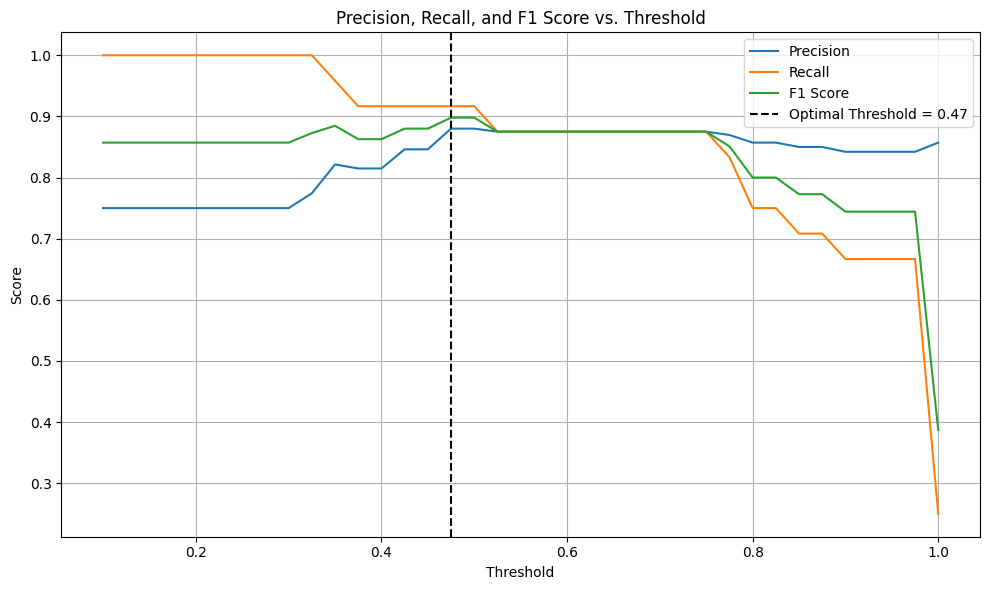

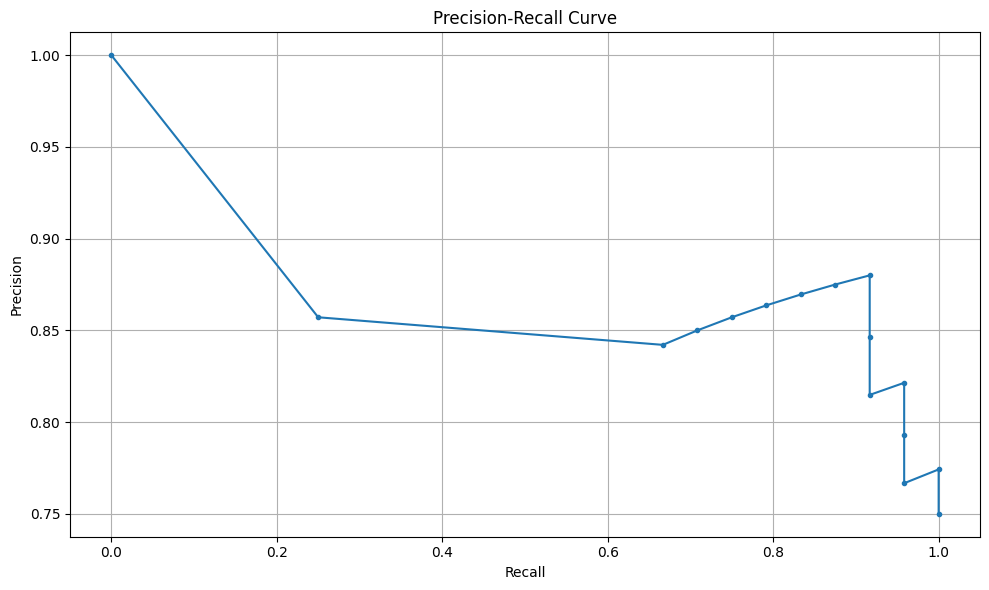


=== Step 3: Algorithm Comparison ===
Comparing matching algorithms...
Evaluating merchant matcher performance...
No test data provided, creating synthetic test data...
Created synthetic test dataset with 32 entries
Category distribution after preprocessing:
Merchant_Category
Retail        9
Banking       8
Restaurant    7
Technology    5
Automotive    3
Name: count, dtype: int64
Processing 32 merchant entries with enhanced matcher...
Progress: 21.9% (7/32) - Elapsed: 0.2s - Est. remaining: 0.6s
Progress: 31.2% (10/32) - Elapsed: 0.5s - Est. remaining: 1.1s
Progress: 40.6% (13/32) - Elapsed: 1.0s - Est. remaining: 1.5s
Progress: 68.8% (22/32) - Elapsed: 1.9s - Est. remaining: 0.9s
Progress: 87.5% (28/32) - Elapsed: 2.5s - Est. remaining: 0.4s
Progress: 96.9% (31/32) - Elapsed: 3.0s - Est. remaining: 0.1s
Progress: 100.0% (32/32) - Elapsed: 3.2s - Est. remaining: 0.0s
Processing completed in 3.22 seconds

Evaluation Results:
Accuracy: 0.8125
Precision: 0.8750
Recall: 0.8750
F1 Score: 0.

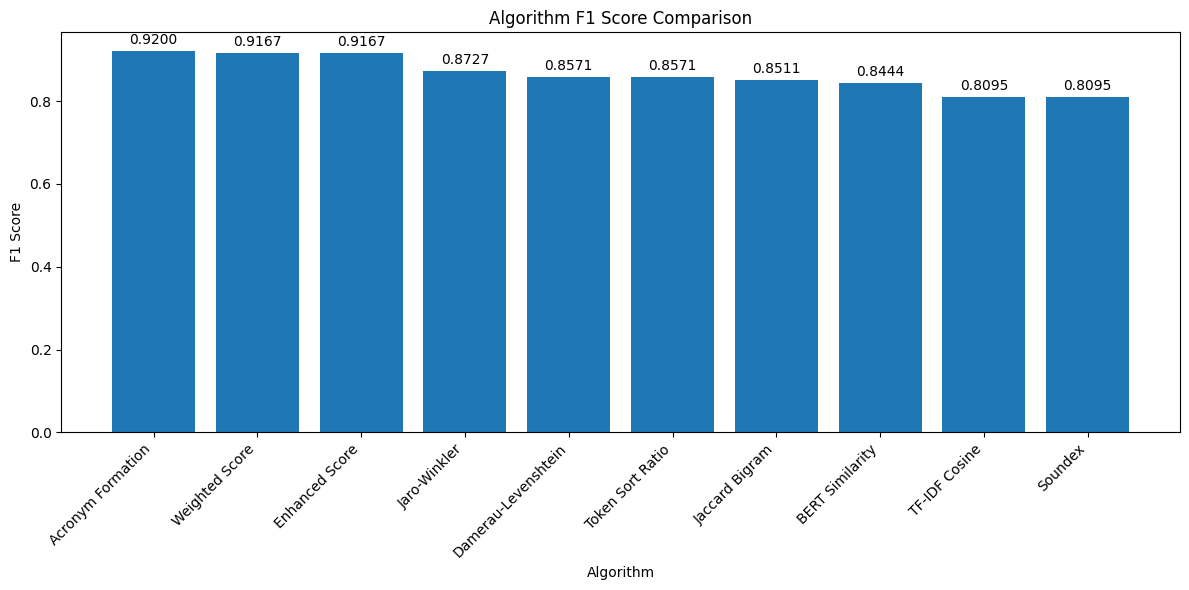

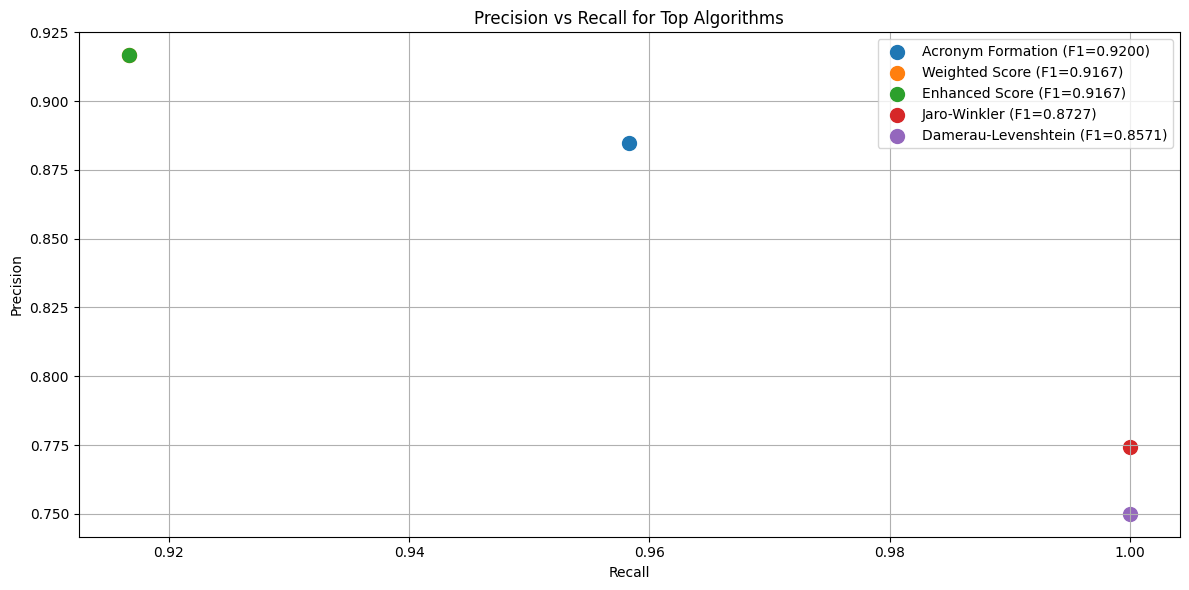


=== Step 4: Error Analysis ===
Analyzing top 5 error cases...

False Positive Analysis (Incorrectly Predicted as Match):

Error Case 1: TGT Brands <-> Tarjay Brands (Score: 1.0000)
Top Individual Algorithm Scores:
  Tfidf Cosine: 1.0000
  Jaro Winkler: 1.0000
  Damerau Levenshtein: 1.0000
  Jaccard Bigram: 1.0000
  Soundex: 1.0000
Possible reason for misclassification:
  BERT semantic similarity may be overvaluing similar contexts

Error Case 2: BOA <-> Bank of Australia (Score: 0.9800)
Top Individual Algorithm Scores:
  Jaro Winkler: 0.8263
  Bert Similarity: 0.6998
  Fuzzy Levenshtein: 0.6207
  Token Sort Ratio: 0.6200
  Contains Ratio: 0.6000
Possible reason for misclassification:

Error Case 3: WF Bank <-> Western Family (Score: 0.9800)
Top Individual Algorithm Scores:
  Contains Ratio: 0.5625
  Aho Corasick: 0.5625
  Jaro Winkler: 0.5506
  Token Sort Ratio: 0.4000
  Fuzzy Levenshtein: 0.4000
Possible reason for misclassification:

False Negative Analysis (Incorrectly Predicted as

In [75]:
# Cell 11: Evaluation and Testing

def evaluate_merchant_matcher(test_data_path=None, gold_standard_column='Expected_Match'):
    """
    Evaluate the merchant matcher against a gold standard dataset
    
    Args:
        test_data_path: Path to test data file (with gold standard annotations)
        gold_standard_column: Column name for the gold standard match status
        
    Returns:
        dict: Evaluation metrics
    """
    print("Evaluating merchant matcher performance...")
    
    # If no test data provided, use built-in test cases
    if test_data_path is None:
        print("No test data provided, creating synthetic test data...")
        
        # Create synthetic test data with known expected outcomes
        test_data = {
            'Acronym': [
                # True matches - should get high scores
                'BoA', 'JPMC', 'WF', 'MCD', 'SBUX', 'TGT', 'MSFT', 'AMZN',
                'WMT', 'HD', 'TM', 'GM', 'GS', 'MS', 'BBY',
                
                # Partial matches - could go either way
                'BofA', 'McDon', 'Micky Ds', 'Wmart', 'Tgt Stores',
                'Msft Corp', 'Amaz', 'JPM Co', 'Home Dep',
                
                # False matches - should get low scores
                'BOA', 'JPM', 'WF Bank', 'MCD Restaurant', 'SB Coffee',
                'MSFT Solutions', 'GMC Trucks', 'TGT Brands'
            ],
            'Full_Name': [
                # Matches for true matches
                'Bank of America', 'JPMorgan Chase', 'Wells Fargo', 'McDonalds',
                'Starbucks', 'Target', 'Microsoft', 'Amazon',
                'Walmart', 'Home Depot', 'Toyota Motors', 'General Motors',
                'Goldman Sachs', 'Morgan Stanley', 'Best Buy',
                
                # Matches for partial matches
                'Bank of America Corp', 'McDonalds Corporation', 'McDonalds Restaurants',
                'Walmart Stores', 'Target Corporation', 'Microsoft Inc',
                'Amazon.com Inc', 'JP Morgan', 'The Home Depot',
                
                # Non-matches
                'Bank of Australia', 'Johnson & Johnson', 'Western Family',
                'Michaels Craft Store', 'Seattle Bread Company',
                'Micro Soft Tech', 'General Mills', 'Tarjay Brands'
            ],
            'Merchant_Category': [
                # Categories for true matches
                'Banking', 'Banking', 'Banking', 'Restaurant', 'Restaurant',
                'Retail', 'Technology', 'Technology', 'Retail', 'Retail',
                'Automotive', 'Automotive', 'Banking', 'Banking', 'Retail',
                
                # Categories for partial matches
                'Banking', 'Restaurant', 'Restaurant', 'Retail', 'Retail',
                'Technology', 'Technology', 'Banking', 'Retail',
                
                # Categories for false matches
                'Banking', 'Healthcare', 'Retail', 'Restaurant', 'Restaurant',
                'Technology', 'Food', 'Retail'
            ],
            'Expected_Match': [
                # Expected outcomes for true matches
                True, True, True, True, True, True, True, True, 
                True, True, True, True, True, True, True,
                
                # Expected outcomes for partial matches
                True, True, True, True, True, True, True, True, True,
                
                # Expected outcomes for false matches
                False, False, False, False, False, False, False, False
            ]
        }
        
        test_df = pd.DataFrame(test_data)
        print(f"Created synthetic test dataset with {len(test_df)} entries")
    else:
        # Load test data from file
        try:
            if test_data_path.lower().endswith('.csv'):
                test_df = pd.read_csv(test_data_path)
            else:
                test_df = pd.read_excel(test_data_path)
            
            print(f"Loaded test data from {test_data_path} with {len(test_df)} entries")
            
            # Verify that gold standard column exists
            if gold_standard_column not in test_df.columns:
                raise ValueError(f"Gold standard column '{gold_standard_column}' not found in test data")
        except Exception as e:
            print(f"Error loading test data: {e}")
            return None
    
    # Preprocess test data
    processed_df = preprocess_merchant_data(test_df)
    
    # Compute scores
    results_df = process_merchant_data(processed_df, merchant_matcher)
    
    # Add binary prediction based on threshold
    match_threshold = 0.75  # This is the "Probable Match" threshold
    results_df['Predicted_Match'] = results_df['Enhanced_Score'] >= match_threshold
    
    # Calculate evaluation metrics
    try:
        from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
        
        # Convert expected values to boolean
        results_df['Expected_Match'] = results_df[gold_standard_column].astype(bool)
        
        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            results_df['Expected_Match'], 
            results_df['Predicted_Match'],
            average='binary'
        )
        
        accuracy = accuracy_score(results_df['Expected_Match'], results_df['Predicted_Match'])
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(results_df['Expected_Match'], results_df['Predicted_Match']).ravel()
        
        print("\nEvaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"True Positives: {tp}")
        print(f"True Negatives: {tn}")
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        
        # Analyze errors
        print("\nAnalyzing errors...")
        
        # False positives
        fp_df = results_df[(results_df['Predicted_Match'] == True) & (results_df['Expected_Match'] == False)]
        if len(fp_df) > 0:
            print(f"\nFalse Positives ({len(fp_df)}):")
            for _, row in fp_df.iterrows():
                print(f"  {row['Acronym']} <-> {row['Full_Name']} (Score: {row['Enhanced_Score']:.4f})")
        
        # False negatives
        fn_df = results_df[(results_df['Predicted_Match'] == False) & (results_df['Expected_Match'] == True)]
        if len(fn_df) > 0:
            print(f"\nFalse Negatives ({len(fn_df)}):")
            for _, row in fn_df.iterrows():
                print(f"  {row['Acronym']} <-> {row['Full_Name']} (Score: {row['Enhanced_Score']:.4f})")
        
        # Return metrics
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_positives': tp,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'results_df': results_df
        }
    
    except ImportError:
        print("Warning: scikit-learn not available. Computing basic metrics...")
        
        # Convert expected values to boolean
        results_df['Expected_Match'] = results_df[gold_standard_column].astype(bool)
        
        # Calculate basic metrics
        tp = sum((results_df['Predicted_Match'] == True) & (results_df['Expected_Match'] == True))
        tn = sum((results_df['Predicted_Match'] == False) & (results_df['Expected_Match'] == False))
        fp = sum((results_df['Predicted_Match'] == True) & (results_df['Expected_Match'] == False))
        fn = sum((results_df['Predicted_Match'] == False) & (results_df['Expected_Match'] == True))
        
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print("\nBasic Evaluation Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_positives': tp,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'results_df': results_df
        }

def find_optimal_threshold(test_data_path=None, gold_standard_column='Expected_Match'):
    """
    Find the optimal threshold for classifying merchant matches
    
    Args:
        test_data_path: Path to test data file
        gold_standard_column: Column name for the gold standard match status
        
    Returns:
        float: Optimal threshold value
    """
    print("Finding optimal threshold for merchant matching...")
    
    # Get test data
    if test_data_path is None:
        # Call evaluate_merchant_matcher which will create synthetic data
        eval_results = evaluate_merchant_matcher(None, gold_standard_column)
        results_df = eval_results['results_df']
    else:
        # Load test data from file
        try:
            if test_data_path.lower().endswith('.csv'):
                test_df = pd.read_csv(test_data_path)
            else:
                test_df = pd.read_excel(test_data_path)
            
            print(f"Loaded test data from {test_data_path} with {len(test_df)} entries")
            
            # Verify that gold standard column exists
            if gold_standard_column not in test_df.columns:
                raise ValueError(f"Gold standard column '{gold_standard_column}' not found in test data")
                
            # Preprocess test data
            processed_df = preprocess_merchant_data(test_df)
            
            # Compute scores
            results_df = process_merchant_data(processed_df, merchant_matcher)
            
            # Convert expected values to boolean
            results_df['Expected_Match'] = results_df[gold_standard_column].astype(bool)
        
        except Exception as e:
            print(f"Error loading or processing test data: {e}")
            return None
    
    # Test different threshold values
    try:
        from sklearn.metrics import precision_recall_curve, f1_score
        import matplotlib.pyplot as plt
        
        thresholds = np.linspace(0.1, 1.0, 37)  # Test thresholds from 0.1 to 1.0
        f1_scores = []
        precision_scores = []
        recall_scores = []
        
        # Calculate F1 score for each threshold
        for threshold in thresholds:
            predictions = results_df['Enhanced_Score'] >= threshold
            precision = sum(predictions & results_df['Expected_Match']) / sum(predictions) if sum(predictions) > 0 else 0
            recall = sum(predictions & results_df['Expected_Match']) / sum(results_df['Expected_Match']) if sum(results_df['Expected_Match']) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
        
        # Find optimal threshold (maximizing F1 score)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_f1 = f1_scores[optimal_idx]
        
        print(f"\nOptimal threshold: {optimal_threshold:.4f} (F1 score: {optimal_f1:.4f})")
        print(f"At this threshold:")
        print(f"  Precision: {precision_scores[optimal_idx]:.4f}")
        print(f"  Recall: {recall_scores[optimal_idx]:.4f}")
        
        # Plot the results
        try:
            plt.figure(figsize=(10, 6))
            plt.plot(thresholds, precision_scores, label='Precision')
            plt.plot(thresholds, recall_scores, label='Recall')
            plt.plot(thresholds, f1_scores, label='F1 Score')
            plt.axvline(x=optimal_threshold, color='k', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
            plt.xlabel('Threshold')
            plt.ylabel('Score')
            plt.title('Precision, Recall, and F1 Score vs. Threshold')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Warning: Error creating plot: {e}")
        
        # Also try precision-recall curve
        try:
            # Get precision-recall curve
            precision, recall, pr_thresholds = precision_recall_curve(
                results_df['Expected_Match'], 
                results_df['Enhanced_Score']
            )
            
            # Plot precision-recall curve
            plt.figure(figsize=(10, 6))
            plt.plot(recall, precision, marker='.', label='Precision-Recall curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Warning: Error creating precision-recall plot: {e}")
        
        return {
            'optimal_threshold': optimal_threshold,
            'optimal_f1': optimal_f1,
            'thresholds': thresholds,
            'precision_scores': precision_scores,
            'recall_scores': recall_scores,
            'f1_scores': f1_scores
        }
    
    except ImportError:
        print("Warning: scikit-learn or matplotlib not available. Computing basic optimization...")
        
        # Test different threshold values without plotting
        thresholds = np.linspace(0.1, 1.0, 19)  # Test thresholds from 0.1 to 1.0
        f1_scores = []
        precision_scores = []
        recall_scores = []
        
        # Calculate F1 score for each threshold
        for threshold in thresholds:
            predictions = results_df['Enhanced_Score'] >= threshold
            precision = sum(predictions & results_df['Expected_Match']) / sum(predictions) if sum(predictions) > 0 else 0
            recall = sum(predictions & results_df['Expected_Match']) / sum(results_df['Expected_Match']) if sum(results_df['Expected_Match']) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
        
        # Find optimal threshold (maximizing F1 score)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        optimal_f1 = f1_scores[optimal_idx]
        
        print(f"\nOptimal threshold: {optimal_threshold:.4f} (F1 score: {optimal_f1:.4f})")
        print(f"At this threshold:")
        print(f"  Precision: {precision_scores[optimal_idx]:.4f}")
        print(f"  Recall: {recall_scores[optimal_idx]:.4f}")
        
        # Print table of results
        print("\nThreshold\tPrecision\tRecall\t\tF1 Score")
        print("-" * 60)
        for i, t in enumerate(thresholds):
            print(f"{t:.2f}\t\t{precision_scores[i]:.4f}\t\t{recall_scores[i]:.4f}\t\t{f1_scores[i]:.4f}")
        
        return {
            'optimal_threshold': optimal_threshold,
            'optimal_f1': optimal_f1,
            'thresholds': thresholds,
            'precision_scores': precision_scores,
            'recall_scores': recall_scores,
            'f1_scores': f1_scores
        }

def compare_algorithms(test_data_path=None, gold_standard_column='Expected_Match'):
    """
    Compare different matching algorithms on the same test data
    
    Args:
        test_data_path: Path to test data file
        gold_standard_column: Column name for the gold standard match status
        
    Returns:
        DataFrame: Comparison results
    """
    print("Comparing matching algorithms...")
    
    # Get test data
    if test_data_path is None:
        # Create synthetic test data
        eval_results = evaluate_merchant_matcher(None, gold_standard_column)
        test_df = eval_results['results_df'][['Acronym', 'Full_Name', 'Merchant_Category', 'Expected_Match']]
    else:
        # Load test data from file
        try:
            if test_data_path.lower().endswith('.csv'):
                test_df = pd.read_csv(test_data_path)
            else:
                test_df = pd.read_excel(test_data_path)
                
            # Verify that gold standard column exists
            if gold_standard_column not in test_df.columns:
                raise ValueError(f"Gold standard column '{gold_standard_column}' not found in test data")
                
            # Convert expected values to boolean
            test_df['Expected_Match'] = test_df[gold_standard_column].astype(bool)
        
        except Exception as e:
            print(f"Error loading test data: {e}")
            return None
    
    # Preprocess test data
    processed_df = preprocess_merchant_data(test_df)
    
    # Define algorithms to compare
    algorithms = {
        'Jaro-Winkler': lambda a, f, d: merchant_matcher.jaro_winkler_similarity(a, f, d),
        'Damerau-Levenshtein': lambda a, f, d: merchant_matcher.damerau_levenshtein_similarity(a, f, d),
        'TF-IDF Cosine': lambda a, f, d: merchant_matcher.tfidf_cosine_similarity(a, f, d),
        'Jaccard Bigram': lambda a, f, d: merchant_matcher.jaccard_bigram_similarity(a, f, d),
        'Soundex': lambda a, f, d: merchant_matcher.soundex_similarity(a, f, d),
        'Token Sort Ratio': lambda a, f, d: merchant_matcher.token_sort_ratio_similarity(a, f, d),
        'Acronym Formation': lambda a, f, d: merchant_matcher.enhanced_acronym_formation_score(a, f, d),
        'BERT Similarity': lambda a, f, d: merchant_matcher.bert_similarity(a, f, d) if hasattr(merchant_matcher, 'bert_similarity') else 0,
        'Weighted Score': lambda a, f, d: merchant_matcher.compute_weighted_score(a, f, d),
        'Enhanced Score': lambda a, f, d: merchant_matcher.compute_enhanced_score(a, f, d)
    }
    
    # Evaluate each algorithm
    algorithm_results = {}
    algorithm_metrics = {}
    
    for name, algorithm in algorithms.items():
        print(f"Evaluating {name}...")
        scores = []
        
        # Calculate scores for each pair
        for _, row in processed_df.iterrows():
            acronym = row['Acronym']
            full_name = row['Full_Name']
            domain = row['Merchant_Category'] if 'Merchant_Category' in row else None
            score = algorithm(acronym, full_name, domain)
            scores.append(score)
        
        # Add scores to results
        processed_df[f'{name}_Score'] = scores
        
        # Find optimal threshold for this algorithm
        thresholds = np.linspace(0.1, 1.0, 19)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            predictions = np.array(scores) >= threshold
            true_labels = processed_df['Expected_Match'].values
            
            # Calculate metrics
            tp = sum(predictions & true_labels)
            fp = sum(predictions & ~true_labels)
            fn = sum(~predictions & true_labels)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        # Calculate final metrics at optimal threshold
        predictions = np.array(scores) >= best_threshold
        true_labels = processed_df['Expected_Match'].values
        
        tp = sum(predictions & true_labels)
        fp = sum(predictions & ~true_labels)
        fn = sum(~predictions & true_labels)
        tn = sum(~predictions & ~true_labels)
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / len(true_labels) if len(true_labels) > 0 else 0
        
        # Store metrics
        algorithm_metrics[name] = {
            'threshold': best_threshold,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn
        }
        
        # Store predictions
        algorithm_results[name] = predictions
    
    # Create comparison table
    metrics_df = pd.DataFrame({
        'Algorithm': list(algorithm_metrics.keys()),
        'Threshold': [m['threshold'] for m in algorithm_metrics.values()],
        'Accuracy': [m['accuracy'] for m in algorithm_metrics.values()],
        'Precision': [m['precision'] for m in algorithm_metrics.values()],
        'Recall': [m['recall'] for m in algorithm_metrics.values()],
        'F1 Score': [m['f1_score'] for m in algorithm_metrics.values()]
    })
    
    # Sort by F1 score
    metrics_df = metrics_df.sort_values('F1 Score', ascending=False).reset_index(drop=True)
    
    # Print comparison table
    print("\nAlgorithm Comparison Results:")
    print(metrics_df.to_string(index=False, float_format='%.4f'))
    
    # Plot comparison if matplotlib is available
    try:
        import matplotlib.pyplot as plt
        
        # Bar chart for F1 scores
        plt.figure(figsize=(12, 6))
        bars = plt.bar(metrics_df['Algorithm'], metrics_df['F1 Score'])
        plt.xlabel('Algorithm')
        plt.ylabel('F1 Score')
        plt.title('Algorithm F1 Score Comparison')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom')
        
        plt.show()
        
        # Precision-Recall comparison for top 5 algorithms
        top_algorithms = metrics_df['Algorithm'].head(5).tolist()
        
        plt.figure(figsize=(12, 6))
        
        for algorithm in top_algorithms:
            precision = algorithm_metrics[algorithm]['precision']
            recall = algorithm_metrics[algorithm]['recall']
            plt.scatter(recall, precision, label=f"{algorithm} (F1={algorithm_metrics[algorithm]['f1_score']:.4f})", s=100)
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision vs Recall for Top Algorithms')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Matplotlib not available for visualization.")
    
    return {
        'metrics_df': metrics_df,
        'algorithm_metrics': algorithm_metrics,
        'algorithm_results': algorithm_results,
        'processed_df': processed_df
    }

def visualize_error_cases(results_df, num_cases=5):
    """
    Visualize and analyze error cases to understand why they're misclassified
    
    Args:
        results_df: DataFrame with matching results
        num_cases: Number of error cases to visualize
        
    Returns:
        dict: Analysis of error cases
    """
    print(f"Analyzing top {num_cases} error cases...")
    
    # Ensure required columns exist
    required_cols = ['Acronym', 'Full_Name', 'Enhanced_Score', 'Expected_Match', 'Predicted_Match']
    if not all(col in results_df.columns for col in required_cols):
        print("Error: Required columns missing from results DataFrame")
        return None
    
    # Find false positives (predicted match but actually not a match)
    fp_df = results_df[(results_df['Predicted_Match'] == True) & (results_df['Expected_Match'] == False)]
    fp_df = fp_df.sort_values('Enhanced_Score', ascending=False).head(num_cases)
    
    # Find false negatives (predicted not a match but actually a match)
    fn_df = results_df[(results_df['Predicted_Match'] == False) & (results_df['Expected_Match'] == True)]
    fn_df = fn_df.sort_values('Enhanced_Score', ascending=True).head(num_cases)
    
    # Analyze false positives
    print("\nFalse Positive Analysis (Incorrectly Predicted as Match):")
    fp_analysis = {}
    
    for i, (_, row) in enumerate(fp_df.iterrows()):
        acronym = row['Acronym']
        full_name = row['Full_Name']
        score = row['Enhanced_Score']
        
        print(f"\nError Case {i+1}: {acronym} <-> {full_name} (Score: {score:.4f})")
        
        # Get all similarity scores
        scores = merchant_matcher.get_all_similarity_scores(acronym, full_name)
        
        # Display top scores
        top_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:5]
        print("Top Individual Algorithm Scores:")
        for algo, algo_score in top_scores:
            print(f"  {algo.replace('_', ' ').title()}: {algo_score:.4f}")
        
        # Check for patterns
        patterns = merchant_matcher.detect_complex_business_patterns(acronym, full_name)
        if patterns:
            print("Detected Business Patterns:")
            for pattern, pattern_score in patterns.items():
                print(f"  {pattern.replace('_', ' ').title()}: {pattern_score:.4f}")
        
        # Explain issue
        print("Possible reason for misclassification:")
        if any(pattern in ['inverted_agency_structure', 'bank_name_inversion'] for pattern in patterns):
            print("  Structure pattern detection may be too aggressive")
        
        if any(score > 0.9 for algo, score in scores.items() if 'bert' in algo):
            print("  BERT semantic similarity may be overvaluing similar contexts")
        
        if any(score > 0.9 for algo, score in scores.items() if 'acronym' in algo):
            print("  Acronym formation detection may be too lenient")
        
        # Store analysis
        fp_analysis[i] = {
            'acronym': acronym,
            'full_name': full_name,
            'score': score,
            'top_scores': top_scores,
            'patterns': patterns
        }
    
    # Analyze false negatives
    print("\nFalse Negative Analysis (Incorrectly Predicted as Non-Match):")
    fn_analysis = {}
    
    for i, (_, row) in enumerate(fn_df.iterrows()):
        acronym = row['Acronym']
        full_name = row['Full_Name']
        score = row['Enhanced_Score']
        
        print(f"\nError Case {i+1}: {acronym} <-> {full_name} (Score: {score:.4f})")
        
        # Get all similarity scores
        scores = merchant_matcher.get_all_similarity_scores(acronym, full_name)
        
        # Display top scores
        top_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:5]
        print("Top Individual Algorithm Scores:")
        for algo, algo_score in top_scores:
            print(f"  {algo.replace('_', ' ').title()}: {algo_score:.4f}")
        
        # Check for patterns
        patterns = merchant_matcher.detect_complex_business_patterns(acronym, full_name)
        if patterns:
            print("Detected Business Patterns:")
            for pattern, pattern_score in patterns.items():
                print(f"  {pattern.replace('_', ' ').title()}: {pattern_score:.4f}")
        
        # Explain issue
        print("Possible reason for misclassification:")
        if all(score < 0.5 for algo, score in scores.items() if 'acronym' in algo):
            print("  No strong acronym formation detected")
        
        if all(score < 0.7 for algo, score in scores.items() if 'jaro' in algo or 'levenshtein' in algo):
            print("  Low string similarity scores")
        
        if not patterns:
            print("  No business patterns detected")
        
        # Store analysis
        fn_analysis[i] = {
            'acronym': acronym,
            'full_name': full_name,
            'score': score,
            'top_scores': top_scores,
            'patterns': patterns
        }
    
    # Return analysis results
    return {
        'false_positives': fp_analysis,
        'false_negatives': fn_analysis,
        'fp_df': fp_df,
        'fn_df': fn_df
    }

def cross_validate_merchant_matcher(test_data_path=None, gold_standard_column='Expected_Match', n_folds=5):
    """
    Perform cross-validation to assess model stability
    
    Args:
        test_data_path: Path to test data file
        gold_standard_column: Column name for the gold standard match status
        n_folds: Number of cross-validation folds
        
    Returns:
        dict: Cross-validation results
    """
    print(f"Performing {n_folds}-fold cross-validation...")
    
    # Get test data
    if test_data_path is None:
        # Create synthetic test data
        eval_results = evaluate_merchant_matcher(None, gold_standard_column)
        test_df = eval_results['results_df'][['Acronym', 'Full_Name', 'Merchant_Category', 'Expected_Match']]
    else:
        # Load test data from file
        try:
            if test_data_path.lower().endswith('.csv'):
                test_df = pd.read_csv(test_data_path)
            else:
                test_df = pd.read_excel(test_data_path)
                
            # Verify that gold standard column exists
            if gold_standard_column not in test_df.columns:
                raise ValueError(f"Gold standard column '{gold_standard_column}' not found in test data")
                
            # Convert expected values to boolean
            test_df['Expected_Match'] = test_df[gold_standard_column].astype(bool)
        
        except Exception as e:
            print(f"Error loading test data: {e}")
            return None
    
    # Preprocess test data
    processed_df = preprocess_merchant_data(test_df)
    
    # Check for sufficient data
    if len(processed_df) < n_folds * 2:
        print(f"Warning: Not enough data for {n_folds} folds. Need at least {n_folds * 2} samples.")
        n_folds = max(2, len(processed_df) // 2)
        print(f"Reducing to {n_folds} folds.")
    
    # Create folds
    try:
        from sklearn.model_selection import KFold
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        folds = list(kf.split(processed_df))
    except ImportError:
        print("Warning: scikit-learn not available. Using manual fold creation.")
        # Manual fold creation
        indices = np.random.permutation(len(processed_df))
        fold_size = len(processed_df) // n_folds
        folds = []
        for i in range(n_folds):
            test_indices = indices[i*fold_size:(i+1)*fold_size]
            train_indices = np.setdiff1d(indices, test_indices)
            folds.append((train_indices, test_indices))
    
    # Perform cross-validation
    fold_results = []
    
    for fold, (train_idx, test_idx) in enumerate(folds):
        print(f"\nProcessing fold {fold+1}/{n_folds}...")
        
        # Split data
        train_df = processed_df.iloc[train_idx]
        test_df = processed_df.iloc[test_idx]
        
        # Process data
        results_df = process_merchant_data(test_df, merchant_matcher)
        
        # Find optimal threshold using training data
        train_results = process_merchant_data(train_df, merchant_matcher)
        thresholds = np.linspace(0.1, 1.0, 19)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            predictions = train_results['Enhanced_Score'] >= threshold
            true_labels = train_df['Expected_Match'].values
            
            # Calculate metrics
            tp = sum(predictions & true_labels)
            fp = sum(predictions & ~true_labels)
            fn = sum(~predictions & true_labels)
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        print(f"  Optimal threshold for fold {fold+1}: {best_threshold:.4f}")
        
        # Evaluate on test data
        results_df['Predicted_Match'] = results_df['Enhanced_Score'] >= best_threshold
        
        # Calculate metrics
        tp = sum((results_df['Predicted_Match'] == True) & (test_df['Expected_Match'] == True))
        tn = sum((results_df['Predicted_Match'] == False) & (test_df['Expected_Match'] == False))
        fp = sum((results_df['Predicted_Match'] == True) & (test_df['Expected_Match'] == False))
        fn = sum((results_df['Predicted_Match'] == False) & (test_df['Expected_Match'] == True))
        
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Store fold results
        fold_results.append({
            'fold': fold + 1,
            'threshold': best_threshold,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn
        })
        
        print(f"  Fold {fold+1} Results:")
        print(f"    Accuracy: {accuracy:.4f}")
        print(f"    Precision: {precision:.4f}")
        print(f"    Recall: {recall:.4f}")
        print(f"    F1 Score: {f1:.4f}")
    
    # Calculate average metrics
    avg_metrics = {
        'accuracy': np.mean([r['accuracy'] for r in fold_results]),
        'precision': np.mean([r['precision'] for r in fold_results]),
        'recall': np.mean([r['recall'] for r in fold_results]),
        'f1_score': np.mean([r['f1_score'] for r in fold_results]),
        'threshold': np.mean([r['threshold'] for r in fold_results])
    }
    
    std_metrics = {
        'accuracy': np.std([r['accuracy'] for r in fold_results]),
        'precision': np.std([r['precision'] for r in fold_results]),
        'recall': np.std([r['recall'] for r in fold_results]),
        'f1_score': np.std([r['f1_score'] for r in fold_results]),
        'threshold': np.std([r['threshold'] for r in fold_results])
    }
    
    print("\nCross-Validation Summary:")
    print(f"  Average Accuracy: {avg_metrics['accuracy']:.4f} (±{std_metrics['accuracy']:.4f})")
    print(f"  Average Precision: {avg_metrics['precision']:.4f} (±{std_metrics['precision']:.4f})")
    print(f"  Average Recall: {avg_metrics['recall']:.4f} (±{std_metrics['recall']:.4f})")
    print(f"  Average F1 Score: {avg_metrics['f1_score']:.4f} (±{std_metrics['f1_score']:.4f})")
    print(f"  Average Threshold: {avg_metrics['threshold']:.4f} (±{std_metrics['threshold']:.4f})")
    
    # Check for potential overfitting
    if std_metrics['f1_score'] > 0.15:
        print("\nWarning: High variance in F1 scores across folds.")
        print("This may indicate that the model's performance is unstable.")
        print("Consider using a larger dataset or a simpler model.")
    
    # Check if thresholds vary significantly
    if std_metrics['threshold'] > 0.1:
        print("\nWarning: High variance in optimal thresholds across folds.")
        print("This may indicate that the optimal threshold is dataset-dependent.")
        print("Consider using a fixed threshold based on business requirements.")
    
    return {
        'fold_results': fold_results,
        'avg_metrics': avg_metrics,
        'std_metrics': std_metrics
    }

print("Evaluation and testing functions defined!")

# Cell 12: Comprehensive Testing and Analysis

def run_comprehensive_evaluation(test_data_path=None, gold_standard_column='Expected_Match'):
    """
    Run a comprehensive evaluation of the merchant matcher
    
    Args:
        test_data_path: Path to test data file
        gold_standard_column: Column name for the gold standard match status
        
    Returns:
        dict: Comprehensive evaluation results
    """
    start_time = time.time()
    print("Running comprehensive evaluation of merchant matcher...")
    
    # Step 1: Basic Evaluation
    print("\n=== Step 1: Basic Evaluation ===")
    basic_eval = evaluate_merchant_matcher(test_data_path, gold_standard_column)
    
    # Step 2: Find Optimal Threshold
    print("\n=== Step 2: Finding Optimal Threshold ===")
    threshold_results = find_optimal_threshold(test_data_path, gold_standard_column)
    
    # Step 3: Algorithm Comparison
    print("\n=== Step 3: Algorithm Comparison ===")
    algorithm_comparison = compare_algorithms(test_data_path, gold_standard_column)
    
    # Step 4: Error Analysis
    print("\n=== Step 4: Error Analysis ===")
    error_analysis = visualize_error_cases(basic_eval['results_df'])
    
    # Step 5: Cross-Validation
    print("\n=== Step 5: Cross-Validation ===")
    cv_results = cross_validate_merchant_matcher(test_data_path, gold_standard_column)
    
    # Calculate total execution time
    total_time = time.time() - start_time
    print(f"\nComprehensive evaluation completed in {total_time:.2f} seconds")
    
    # Return all results
    return {
        'basic_evaluation': basic_eval,
        'threshold_optimization': threshold_results,
        'algorithm_comparison': algorithm_comparison,
        'error_analysis': error_analysis,
        'cross_validation': cv_results,
        'execution_time': total_time
    }

# This can be uncommented to run the comprehensive evaluation

evaluation_results = run_comprehensive_evaluation()

Running comprehensive evaluation of merchant matcher...

=== Step 1: Basic Evaluation ===
Evaluating merchant matcher performance...
No test data provided, creating synthetic test data...
Created synthetic test dataset with 32 entries
Category distribution after preprocessing:
Merchant_Category
Retail        9
Banking       8
Restaurant    7
Technology    5
Automotive    3
Name: count, dtype: int64
Processing 32 merchant entries with enhanced matcher...
Progress: 21.9% (7/32) - Elapsed: 0.1s - Est. remaining: 0.5s
Progress: 31.2% (10/32) - Elapsed: 0.7s - Est. remaining: 1.5s
Progress: 40.6% (13/32) - Elapsed: 1.2s - Est. remaining: 1.8s
Progress: 68.8% (22/32) - Elapsed: 2.2s - Est. remaining: 1.0s
Progress: 87.5% (28/32) - Elapsed: 2.8s - Est. remaining: 0.4s
Progress: 96.9% (31/32) - Elapsed: 3.4s - Est. remaining: 0.1s
Progress: 100.0% (32/32) - Elapsed: 3.6s - Est. remaining: 0.0s
Processing completed in 3.60 seconds

Evaluation Results:
Accuracy: 0.8125
Precision: 0.8750
Recall: 

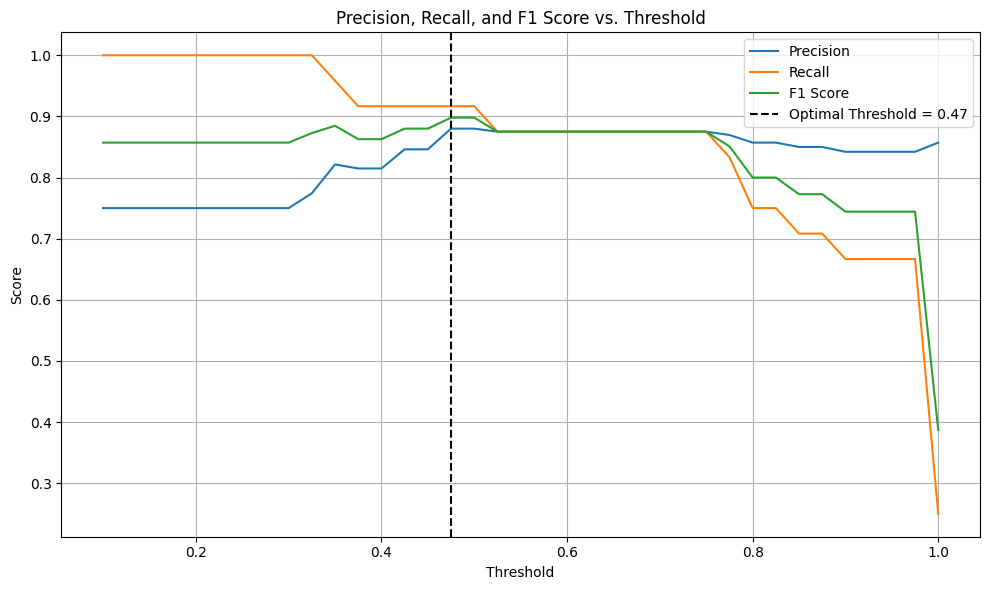

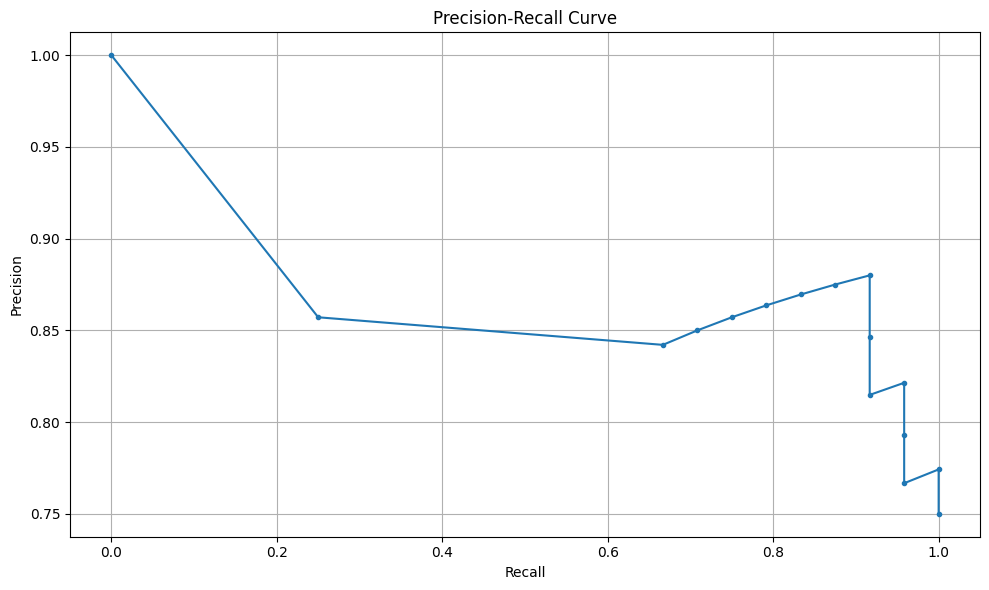


=== Step 3: Algorithm Comparison ===
Comparing matching algorithms...
Evaluating merchant matcher performance...
No test data provided, creating synthetic test data...
Created synthetic test dataset with 32 entries
Category distribution after preprocessing:
Merchant_Category
Retail        9
Banking       8
Restaurant    7
Technology    5
Automotive    3
Name: count, dtype: int64
Processing 32 merchant entries with enhanced matcher...
Progress: 21.9% (7/32) - Elapsed: 0.1s - Est. remaining: 0.5s
Progress: 31.2% (10/32) - Elapsed: 0.5s - Est. remaining: 1.1s
Progress: 40.6% (13/32) - Elapsed: 1.0s - Est. remaining: 1.5s
Progress: 68.8% (22/32) - Elapsed: 1.9s - Est. remaining: 0.9s
Progress: 87.5% (28/32) - Elapsed: 2.5s - Est. remaining: 0.4s
Progress: 96.9% (31/32) - Elapsed: 3.0s - Est. remaining: 0.1s
Progress: 100.0% (32/32) - Elapsed: 3.2s - Est. remaining: 0.0s
Processing completed in 3.19 seconds

Evaluation Results:
Accuracy: 0.8125
Precision: 0.8750
Recall: 0.8750
F1 Score: 0.

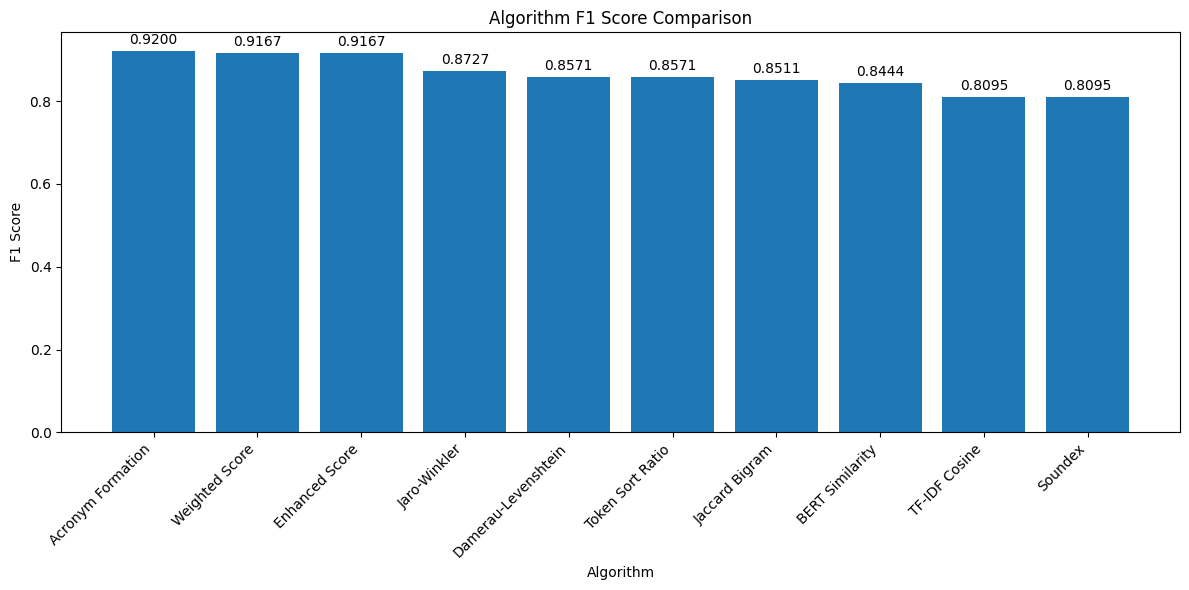

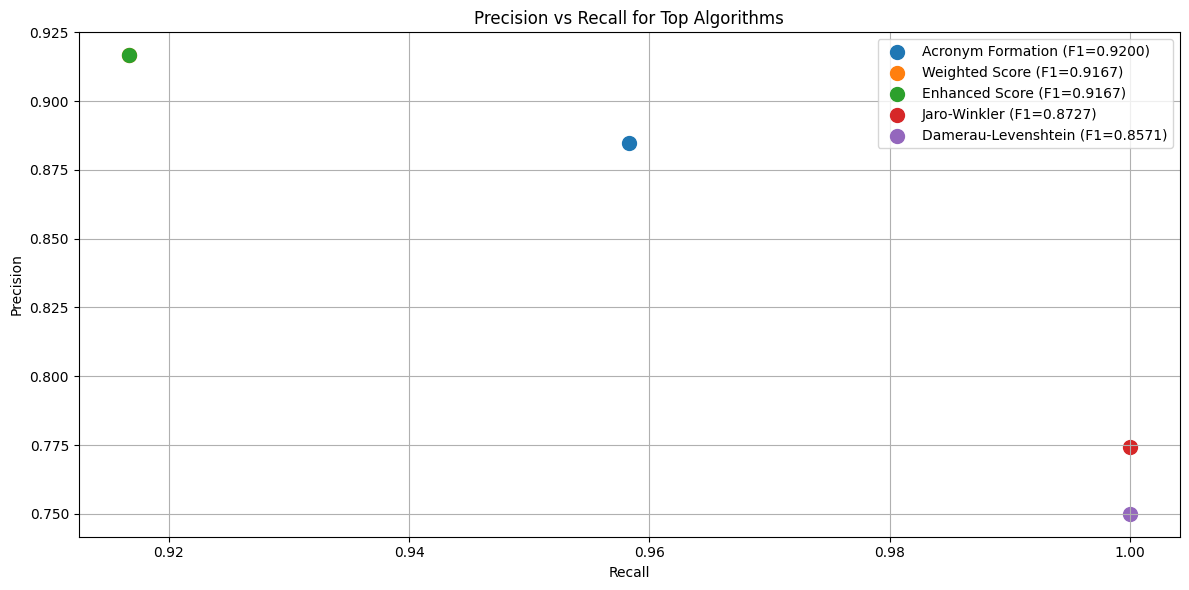


=== Step 4: Error Analysis ===
Analyzing top 5 error cases...

False Positive Analysis (Incorrectly Predicted as Match):

Error Case 1: TGT Brands <-> Tarjay Brands (Score: 1.0000)
Top Individual Algorithm Scores:
  Tfidf Cosine: 1.0000
  Jaro Winkler: 1.0000
  Damerau Levenshtein: 1.0000
  Jaccard Bigram: 1.0000
  Soundex: 1.0000
Possible reason for misclassification:
  BERT semantic similarity may be overvaluing similar contexts

Error Case 2: BOA <-> Bank of Australia (Score: 0.9800)
Top Individual Algorithm Scores:
  Jaro Winkler: 0.8263
  Bert Similarity: 0.6998
  Fuzzy Levenshtein: 0.6207
  Token Sort Ratio: 0.6200
  Contains Ratio: 0.6000
Possible reason for misclassification:

Error Case 3: WF Bank <-> Western Family (Score: 0.9800)
Top Individual Algorithm Scores:
  Contains Ratio: 0.5625
  Aho Corasick: 0.5625
  Jaro Winkler: 0.5506
  Token Sort Ratio: 0.4000
  Fuzzy Levenshtein: 0.4000
Possible reason for misclassification:

False Negative Analysis (Incorrectly Predicted as

In [77]:
# Cell 12: Comprehensive Testing and Analysis

def run_comprehensive_evaluation(test_data_path=None, gold_standard_column='Expected_Match'):
    """
    Run a comprehensive evaluation of the merchant matcher
    
    Args:
        test_data_path: Path to test data file
        gold_standard_column: Column name for the gold standard match status
        
    Returns:
        dict: Comprehensive evaluation results
    """
    start_time = time.time()
    print("Running comprehensive evaluation of merchant matcher...")
    
    # Step 1: Basic Evaluation
    print("\n=== Step 1: Basic Evaluation ===")
    basic_eval = evaluate_merchant_matcher(test_data_path, gold_standard_column)
    
    # Step 2: Find Optimal Threshold
    print("\n=== Step 2: Finding Optimal Threshold ===")
    threshold_results = find_optimal_threshold(test_data_path, gold_standard_column)
    
    # Step 3: Algorithm Comparison
    print("\n=== Step 3: Algorithm Comparison ===")
    algorithm_comparison = compare_algorithms(test_data_path, gold_standard_column)
    
    # Step 4: Error Analysis
    print("\n=== Step 4: Error Analysis ===")
    error_analysis = visualize_error_cases(basic_eval['results_df'])
    
    # Step 5: Cross-Validation
    print("\n=== Step 5: Cross-Validation ===")
    cv_results = cross_validate_merchant_matcher(test_data_path, gold_standard_column)
    
    # Calculate total execution time
    total_time = time.time() - start_time
    print(f"\nComprehensive evaluation completed in {total_time:.2f} seconds")
    
    # Return all results
    return {
        'basic_evaluation': basic_eval,
        'threshold_optimization': threshold_results,
        'algorithm_comparison': algorithm_comparison,
        'error_analysis': error_analysis,
        'cross_validation': cv_results,
        'execution_time': total_time
    }

# This can be uncommented to run the comprehensive evaluation
evaluation_results = run_comprehensive_evaluation()

In [79]:
# Process Acronym_Categorized.xlsx and Export Results
import pandas as pd
import time
import os

def process_acronym_file_and_export_results(input_file="Acronym_Categorized.xlsx", 
                                           output_file="Acronym_Matching_Results.xlsx"):
    """
    Process the Acronym_Categorized.xlsx file and export comprehensive matching results
    
    Args:
        input_file (str): Path to Acronym_Categorized.xlsx file
        output_file (str): Path for the output Excel file with results
        
    Returns:
        DataFrame: Processed results with all matching scores
    """
    start_time = time.time()
    print(f"Loading and processing data from {input_file}...")
    
    # Step 1: Load the data from Acronym_Categorized.xlsx
    try:
        merchant_df = pd.read_excel(input_file)
        print(f"Successfully loaded {len(merchant_df)} records from {input_file}")
        print(f"Columns found: {merchant_df.columns.tolist()}")
        print(f"\nSample data (first 3 rows):")
        print(merchant_df.head(3))
    except Exception as e:
        print(f"Error loading data from {input_file}: {e}")
        return None
    
    # Step 2: Preprocess the data
    print("\nPreprocessing merchant data...")
    processed_df = preprocess_merchant_data(merchant_df)
    
    # Step 3: Process with merchant matcher to get similarity scores
    print("\nCalculating similarity scores using enhanced merchant matcher...")
    results_df = process_merchant_data(processed_df, merchant_matcher)
    
    # Step 4: Add match categories based on score thresholds
    thresholds = {
        'Exact Match': 0.95,
        'Strong Match': 0.85,
        'Probable Match': 0.75,
        'Possible Match': 0.65,
        'Weak Match': 0.50,
        'No Match': 0.0
    }
    print("\nCategorizing matches based on thresholds...")
    categorized_df = add_match_categories(results_df, thresholds)
    
    # Step 5: Export the results
    print(f"\nExporting results to {output_file}...")
    
    try:
        # Create a writer for Excel output
        with pd.ExcelWriter(output_file) as writer:
            # Sheet 1: Main results with all scores
            categorized_df.to_excel(writer, sheet_name="Matching_Results", index=False)
            
            # Sheet 2: Summary statistics
            category_counts = categorized_df['Match_Category'].value_counts().reset_index()
            category_counts.columns = ['Match_Category', 'Count']
            category_counts['Percentage'] = (category_counts['Count'] / len(categorized_df) * 100).round(2)
            
            # Sort by threshold order
            category_order = list(thresholds.keys())
            category_counts['Order'] = category_counts['Match_Category'].map({cat: i for i, cat in enumerate(category_order)})
            category_counts = category_counts.sort_values('Order').drop('Order', axis=1)
            
            category_counts.to_excel(writer, sheet_name="Category_Summary", index=False)
            
            # Sheet 3: Algorithm scores analysis
            # For each merchant pair, get all individual algorithm scores
            analysis_rows = []
            
            # Sample 50 entries (or all if fewer) for detailed algorithm analysis
            sample_size = min(50, len(categorized_df))
            sampled_df = categorized_df.sample(sample_size)
            
            for idx, row in sampled_df.iterrows():
                acronym = row['Acronym']
                full_name = row['Full_Name']
                domain = row['Merchant_Category'] if 'Merchant_Category' in row else None
                
                # Get all algorithm scores
                all_scores = merchant_matcher.get_all_similarity_scores(acronym, full_name, domain)
                
                # Add basic row info
                score_row = {
                    'Acronym': acronym,
                    'Full_Name': full_name,
                    'Domain': domain,
                    'Enhanced_Score': row['Enhanced_Score'],
                    'Match_Category': row['Match_Category']
                }
                
                # Add individual algorithm scores
                for algo, score in all_scores.items():
                    score_row[algo] = score
                
                analysis_rows.append(score_row)
            
            # Create algorithm analysis DataFrame
            if analysis_rows:
                algo_df = pd.DataFrame(analysis_rows)
                algo_df.to_excel(writer, sheet_name="Algorithm_Analysis", index=False)
            
            # Auto-adjust column widths for all sheets
            for sheet_name in writer.sheets:
                worksheet = writer.sheets[sheet_name]
                for i, col in enumerate(categorized_df.columns):
                    # Find the maximum length in the column
                    max_len = max(
                        categorized_df[col].astype(str).map(len).max(),  # max data length
                        len(str(col))  # column name length
                    ) + 2  # adding a little extra space
                    
                    # Set the column width
                    worksheet.set_column(i, i, max_len)
                    
        print(f"Results successfully exported to {output_file}")
        print(f"\nSummary of exported data:")
        print(f"  • Total merchant entries: {len(categorized_df)}")
        
        # Display category distribution
        print("\nMatch Category Distribution:")
        for _, row in category_counts.iterrows():
            print(f"  • {row['Match_Category']}: {row['Count']} entries ({row['Percentage']}%)")
        
    except Exception as e:
        print(f"Error exporting results: {e}")
        return categorized_df
    
    processing_time = time.time() - start_time
    print(f"\nTotal processing time: {processing_time:.2f} seconds")
    
    return categorized_df

# Run the processing and export
output_filename = "Acronym_Matching_Results.xlsx"
result_data = process_acronym_file_and_export_results(
    input_file="Acronym_Categorized.xlsx", 
    output_file=output_filename
)

print(f"\nProcessing complete! Full results available in: {output_filename}")

# Optional: If you want to explore some specific interesting matches from the results
if result_data is not None:
    print("\nSome interesting matches from the results:")
    
    # Show top exact matches
    exact_matches = result_data[result_data['Match_Category'] == 'Exact Match'].head(3)
    if not exact_matches.empty:
        print("\nTop Exact Matches:")
        for _, row in exact_matches.iterrows():
            print(f"  • {row['Acronym']} ↔ {row['Full_Name']} (Score: {row['Enhanced_Score']:.4f})")
    
    # Show some probable matches
    probable_matches = result_data[result_data['Match_Category'] == 'Probable Match'].head(3)
    if not probable_matches.empty:
        print("\nSample Probable Matches:")
        for _, row in probable_matches.iterrows():
            print(f"  • {row['Acronym']} ↔ {row['Full_Name']} (Score: {row['Enhanced_Score']:.4f})")
    
    # Show some of the lowest scoring pairs
    low_matches = result_data.nsmallest(3, 'Enhanced_Score')
    if not low_matches.empty:
        print("\nLowest Scoring Pairs:")
        for _, row in low_matches.iterrows():
            print(f"  • {row['Acronym']} ↔ {row['Full_Name']} (Score: {row['Enhanced_Score']:.4f})")

Loading and processing data from Acronym_Categorized.xlsx...
Successfully loaded 100 records from Acronym_Categorized.xlsx
Columns found: ['Acronym', 'Full Name', 'Merchant Category']

Sample data (first 3 rows):
   Acronym                                          Full Name  \
0      ANZ            Australia and New Zealand Banking Group   
1   Qantas  Queensland and Northern Territory Aerial Services   
2  Telstra                                  Telecom Australia   

  Merchant Category  
0           Banking  
1           Banking  
2           Telecom  

Preprocessing merchant data...
Category distribution after preprocessing:
Merchant_Category
Government         43
Banking             8
Retail              6
Misc Speciality     6
Technology          6
Automotive          5
Restaurant          5
Clothing            4
Medical             3
Telecom             2
Name: count, dtype: int64

Calculating similarity scores using enhanced merchant matcher...
Processing 100 merchant entries w